In [1]:
import numpy as np
import math
from scipy.integrate import quad
from scipy.linalg import eigvalsh
from scipy.optimize import minimize_scalar
from scipy.stats import linregress
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
#kronecker product code for more than 2 inputs
def kron(*matrices):
    result = np.array([[1]])
    for matrix in matrices:
        result = np.kron(result, matrix)
    return result

#Partial Trace Code
def IntegerDigits(n, b, l):
    digits = [0] * l
    pos = l - 1
    while pos != -1:
        digits[pos] = int(n % b)
        n //= b
        pos -= 1
    return digits

def FromDigits(digits, base):
    digits = digits[::-1]
    n = 0
    for i, d in enumerate(digits):
        n += d * base**i
        
    return n

def SwapParts(digits, p1, p2):
    new = np.copy(digits)
    new[p1] = digits[p2]
    new[p2] = digits[p1]
    return new

def dTraceSystem(D,s,dimen):
    Qudits=sorted(s)
    Qudits.reverse()
    TrkM = D
    z=len(Qudits)
    
    for q in range(z):
        n=math.log(TrkM.shape[0],dimen)
        assert n % 1 == 0
        n = int(n)
        
        M=TrkM
        M = np.array(M , dtype = complex)
        k=Qudits[q]
        temp = np.zeros(M.shape[0], dtype=complex)
        if k!=n:
            for j in range(n-k):
                b={0}
                for i in range(dimen**n):
                    digits=IntegerDigits(i,dimen,n)
                    if digits[n-1] != digits[n-j-2] and i not in  b:
                        number=FromDigits(
                            SwapParts(digits, n-1, n-j-2),
                            dimen
                        )
                        b.add(number)

                        temp[:] = M[i, :]
                        M[i, :] = M[number, :]
                        M[number, :] = temp

                        temp[:] = M[:, i]
                        M[:, i] = M[:, number]
                        M[:, number] = temp
        
        TrkM=[]
        for p in range(0,dimen**n,dimen):
            TrkM.append(
                sum(
                    M[p+h, h:dimen**n:dimen]
                    for h in range(dimen)
                )
            )
        TrkM = np.array(TrkM)
    
    return TrkM
#Recall matrix as dTraceSystem(matrix,[systems I want to trace out],dimension of system)


In [3]:
#defining basis vectors

#zero vector and its conjugate transpose                                         
zero= np.array([[1],[0]])
zeroCT=np.conjugate(zero.T)
#one vector and its conjugate transpose
one=np.array([[0],[1]])
oneCT=np.conjugate(one.T)
#plus vector and its conjugate transpose
plus=np.array([[1],[1]])*1/math.sqrt(2)
plusCT=np.conjugate(plus.T)
#minus vector and its conjugate transpose
minus=np.array([[1],[-1]])*1/math.sqrt(2)
minusCT=np.conjugate(minus.T)
#plusy and its conjugate transpose
plusy=np.array([[1],[complex(0.0, 1)]])*1/math.sqrt(2)
plusyCT=np.conjugate(plusy.T)
#minusy and its conjugate transpose
minusy=np.array([[1],[complex(0.0, -1)]])*1/math.sqrt(2)
minusyCT=np.conjugate(minusy.T)
#defining the Bell states
phiplus=(np.kron(zero, zero)+np.kron(one, one))*1/math.sqrt(2)
phiminus=(np.kron(zero, zero)-np.kron(one, one))*1/math.sqrt(2)
psiplus=(np.kron(zero, one)+np.kron(one, zero))*1/math.sqrt(2)
psiminus=(np.kron(zero, one)-np.kron(one, zero))*1/math.sqrt(2)
#defining the outer product of the Bell states
Phiplus=phiplus@np.conjugate(phiplus.T)
Phiminus=phiminus@np.conjugate(phiminus.T)
Psiplus=psiplus@np.conjugate(psiplus.T)
Psiminus=psiminus@np.conjugate(psiminus.T)
#defining Pauli matrices
pauliX=np.array([[0,1],[1,0]])
pauliY=np.array([[0,complex(0,-1)],[complex(0,1),0]])
pauliZ=np.array([[1,0],[0,-1]])

In [4]:
def r(p, q):
    return np.array([
        p[3]*q[0] + p[2]*q[1] + p[1]*q[2] + p[0]*q[3],
        p[2]*q[0] + p[3]*q[1] + p[0]*q[2] + p[1]*q[3],
        p[1]*q[0] + p[0]*q[1] + p[3]*q[2] + p[2]*q[3],
        p[0]*q[0] + p[1]*q[1] + p[2]*q[2] + p[3]*q[3]
    ])

def rNtimes(p, n):
    if n == 1:
        return r(p, p)
    else:
        return r(rNtimes(p, n-1), p)

In [5]:
#Defining parameters for GKP states


# transmissivity for QR setup
def new_eta(L, n):
    alpha_dB_per_km = 0.2
    alpha = (alpha_dB_per_km / 10) * np.log(10)  # convert dB/km to 1/km
    return np.exp(-alpha * L / (n + 1))  # eta ∈ [0, 1]

#Quality of GKP state
def sigmaloss(sigma , L , n):
    eta = new_eta(L , n)
    return np.sqrt(eta * sigma**2 + (1 - eta))


#Error functions
def f(x , mu , sigma , L , n):
    s = sigmaloss(sigma , L , n)
    return np.exp(-(x - mu)**2 / (2 * s**2))/(s * np.sqrt(2*np.pi))

def Pc(sigma , nu , L , n):
    integrand = lambda x: f(x , 0 , sigma , L , n)
    lower = -0.5 * np.sqrt(np.pi) + nu
    upper =  0.5 * np.sqrt(np.pi) - nu
    return quad(integrand, lower, upper)[0] 
    
def Pf(sigma , nu , L , n):
    integrand = lambda x: f(x, 0, sigma, L , n)
    lower = 0.5 * np.sqrt(np.pi) + nu
    upper = 1.5 * np.sqrt(np.pi) - nu
    return 2 * quad(integrand, lower, upper)[0]



#Bell state mixture probabilities


def p1(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pc**2) / (pc + pf)**2

def p2(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pc * pf) / (pc + pf)**2

def p3(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pf**2) / (pc + pf)**2



#Mixture of Bell states

def new_vector(sigma , nu , L , n):
    return np.array([
        p1(sigma , nu , L , n) , 
        p2(sigma , nu , L , n) , 
        p2(sigma , nu , L , n) , 
        p3(sigma , nu , L , n)
        ])


#von Neumann entropy

def vonneumann(mat):
    evals = eigvalsh(mat)
    evals = np.clip(evals, 1e-16 , 1)
    return -np.sum(evals * np.log2(evals))



# hashing bound

def hashing_bound(mat):
    sAB = vonneumann(mat)
    sA = vonneumann(dTraceSystem(mat , [2] , 2))
    sB = vonneumann(dTraceSystem(mat , [1] , 2))
    return max(sA - sAB , sB - sAB)



# chain function

def chain_function(vec , n):
    return rNtimes(vec , n)



# building the chain states

def BSM_mixture_chain(vec):
    return vec[0] * Phiplus + vec[1] * Phiminus + vec[2] * Psiplus + vec[3] * Psiminus
 

# defining the probability of success for repeaters

# BSM swaps are no longer deterministic
# we model realistic repeater architectures
# these architectures perform probabilistic entanglement generation
# we only succeed when ALL elementary links generate entangled pairs
# AND all BSM swaps succeed

# these probability of successes have been adjusted in each respectiv hashing rate definition

In [6]:
#GKP chains

# hashing rate
def hashing_rate(sigma , nu , L , n , M , q , tau , m):

    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)

    # probability of BSM swap
    pSWAP = (pc + pf)**2
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    vec = chain_function(new_vector(sigma , nu , L , n) , n)
    
    return rate * hashing_bound(BSM_mixture_chain(vec))


# optimal hashing rate
def optimal_hashing_rate(sigma , L , n , M , q , tau , m , return_nu = False):
    def neg_rate(nu):
        try:
            value = hashing_rate(sigma , nu , L , n , M , q , tau , m)
            return -value if value > 0 else np.inf
        except Exception:
            return np.inf

    result = minimize_scalar(neg_rate, bounds=(0, 0.5 * np.sqrt(np.pi)), method='bounded')
    rate = -result.fun

    if not np.isfinite(rate) or rate <= 0:
        rate = 0.0

    if return_nu:
        return rate , result.x  # return rate, ν
    return rate

In [7]:
# Single Rail

def SingleRailState(eta , gamma , Pd , Vis):
    return 2 * np.array(
        [
            [(1 - Pd)*Pd*gamma**2, 0 , 0 , 0], 
            [0 , (1 - Pd) * Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta)* Vis , 0] ,
            [0 , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) * Vis , (1 - Pd)* Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta), 0] ,
            [0 , 0 , 0, (1 - Pd) * Pd * ((1 - gamma)**2) * ((1 - np.sqrt(eta))**2) + ((1 - Pd)**2) * ((1 - gamma)**2) * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for single-rail entangled memory pair
def QStateSingle(eta , gamma , Pd , Vis):
    state = SingleRailState(eta , gamma , Pd , Vis)
    tr = np.trace(state)
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# Building chains of SR encoded states

def SRinitialState(eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho = kron(QStateSingle(eta , gamma , 0 , 1) , QStateSingle(eta , gamma , 0 , 1))
    rho = BSM @ rho @ np.conjugate(BSM.T)
    rho = rho / np.trace(rho)
    return dTraceSystem(rho , [2 , 3] , 2)

def SRextendState(rho , eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho_ext = kron(rho , QStateSingle(eta , gamma , 0 , 1))
    rho_ext = BSM @ rho_ext @ np.conjugate(BSM.T)
    rho_ext = rho_ext / np.trace(rho_ext)
    return dTraceSystem(rho_ext , [2 , 3] , 2)

def SRchainState(L , gamma , n):
    eta = new_eta(L , n)
    if n == 1:
        return QStateSingle(eta , gamma , 0 , 1)
    rho = SRinitialState(eta , gamma)
    for _ in range(n - 2):
        rho = SRextendState(rho , eta , gamma)
    return rho

# Single-Rail Hashing Rate
def SRhashingrate(L , gamma , n , M , q , tau , m):

    eta = new_eta(L , n)
    PsuccSR = np.trace(SingleRailState(eta , gamma , 0 , 1))

    # probability of BSM swap
    pSWAP = PsuccSR
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    rho = SRchainState(L , gamma , n)
    return rate * hashing_bound(rho)

# optimising over gamma
def optimal_SRhashingrate(L , n , M , q , tau , m):
    gammas = np.linspace(0, 1, 100)
    best_rate = 0.0
    best_gamma = None
    for gamma in gammas:
        try:
            rate = SRhashingrate(L , gamma, n , M , q , tau , m)
            # ensuring that the hashing rate is a valid number
            if not np.isnan(rate) and not np.isinf(rate):
                if rate > best_rate:
                    best_rate = rate
                    best_gamma = gamma
        except Exception as e:
            # print(f"Skipping gamma = {gamma}: {e}")
            continue
    return best_rate , best_gamma if best_gamma is not None else 0


In [8]:
# Dual Rail
def DualRailState(eta , Pd , Vis):
    return 4 * np.array(
        [
            [1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta), 0 , 0 , 0] ,
            [0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 1/16 * ((1 - Pd)**4) * eta * Vis**2 , 0] ,
            [0 , 1/16 * ((1 - Pd)**4) *eta * Vis**2 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 0] ,
            [0 , 0 , 0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for dual-rail entangled memory pair
def QStateDual(eta , Pd , Vis):
    state = DualRailState(eta , Pd , Vis)
    tr = np.trace(DualRailState(eta , Pd , Vis))
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# hashing rate
def DRhashingrate(L , n , M , q , tau , m):
    eta = new_eta(L , n)
    PsuccDR = np.trace(DualRailState(eta , 0 , 1))

    # probability of BSM swap
    pSWAP = PsuccDR
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    if n == 1:
        return rate * hashing_bound(QStateDual(eta , 0 , 1))
    else:
        vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta , 0 , 1)) , n - 1)
        rho = BSM_mixture_chain(vec)
        return rate * hashing_bound(rho)

In [11]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 200 , 2)


sigma1 = np.sqrt(0.01)
rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 10 , 0.7 , 1e-8 , 1) for L in Ls]


ratesSR1 = [optimal_SRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 1)[0] for L in Ls]
ratesSR2 = [optimal_SRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 1)[0] for L in Ls]
ratesSR4 = [optimal_SRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 1)[0] for L in Ls]
ratesSR8 = [optimal_SRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 1)[0] for L in Ls]
ratesSR16 = [optimal_SRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 1)[0] for L in Ls]


ratesDR1 = [DRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR2 = [DRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR4 = [DRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR8 = [DRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 1) for L in Ls]
ratesDR16 = [DRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 1) for L in Ls]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [14]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 200 , 2)


sigma1 = np.sqrt(0.01)
m2rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 10 , 0.7 , 1e-8 , 2) for L in Ls]


m2ratesSR1 = [optimal_SRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 2)[0] for L in Ls]
m2ratesSR2 = [optimal_SRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 2)[0] for L in Ls]
m2ratesSR4 = [optimal_SRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 2)[0] for L in Ls]
m2ratesSR8 = [optimal_SRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 2)[0] for L in Ls]
m2ratesSR16 = [optimal_SRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 2)[0] for L in Ls]


m2ratesDR1 = [DRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR2 = [DRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR4 = [DRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR8 = [DRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 2) for L in Ls]
m2ratesDR16 = [DRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 2) for L in Ls]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [15]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 200 , 2)


sigma1 = np.sqrt(0.01)
m4rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 10 , 0.7 , 1e-8 , 4) for L in Ls]


m4ratesSR1 = [optimal_SRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 4)[0] for L in Ls]
m4ratesSR2 = [optimal_SRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 4)[0] for L in Ls]
m4ratesSR4 = [optimal_SRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 4)[0] for L in Ls]
m4ratesSR8 = [optimal_SRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 4)[0] for L in Ls]
m4ratesSR16 = [optimal_SRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 4)[0] for L in Ls]


m4ratesDR1 = [DRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR2 = [DRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR4 = [DRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR8 = [DRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 4) for L in Ls]
m4ratesDR16 = [DRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 4) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [16]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 200 , 2)


sigma1 = np.sqrt(0.01)
m8rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 10 , 0.7 , 1e-8 , 8) for L in Ls]


m8ratesSR1 = [optimal_SRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 8)[0] for L in Ls]
m8ratesSR2 = [optimal_SRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 8)[0] for L in Ls]
m8ratesSR4 = [optimal_SRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 8)[0] for L in Ls]
m8ratesSR8 = [optimal_SRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 8)[0] for L in Ls]
m8ratesSR16 = [optimal_SRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 8)[0] for L in Ls]


m8ratesDR1 = [DRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR2 = [DRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR4 = [DRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR8 = [DRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 8) for L in Ls]
m8ratesDR16 = [DRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 8) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [17]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 200 , 2)


sigma1 = np.sqrt(0.01)
m100rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 10 , 0.7 , 1e-8 , 100) for L in Ls]


m100ratesSR1 = [optimal_SRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 100)[0] for L in Ls]
m100ratesSR2 = [optimal_SRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 100)[0] for L in Ls]
m100ratesSR4 = [optimal_SRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 100)[0] for L in Ls]
m100ratesSR8 = [optimal_SRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 100)[0] for L in Ls]
m100ratesSR16 = [optimal_SRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 100)[0] for L in Ls]


m100ratesDR1 = [DRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR2 = [DRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR4 = [DRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR8 = [DRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 100) for L in Ls]
m100ratesDR16 = [DRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 100) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [18]:
plt.figure(dpi  = 1000)

Ls = np.arange(0 , 200 , 2)


sigma1 = np.sqrt(0.01)
m1000rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]


m1000ratesSR1 = [optimal_SRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 1000)[0] for L in Ls]
m1000ratesSR2 = [optimal_SRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 1000)[0] for L in Ls]
m1000ratesSR4 = [optimal_SRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 1000)[0] for L in Ls]
m1000ratesSR8 = [optimal_SRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 1000)[0] for L in Ls]
m1000ratesSR16 = [optimal_SRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 1000)[0] for L in Ls]


m1000ratesDR1 = [DRhashingrate(L , 1 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000ratesDR2 = [DRhashingrate(L , 2 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000ratesDR4 = [DRhashingrate(L , 4 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000ratesDR8 = [DRhashingrate(L , 8 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]
m1000ratesDR16 = [DRhashingrate(L , 16 , 10 , 0.7 , 1e-8 , 1000) for L in Ls]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

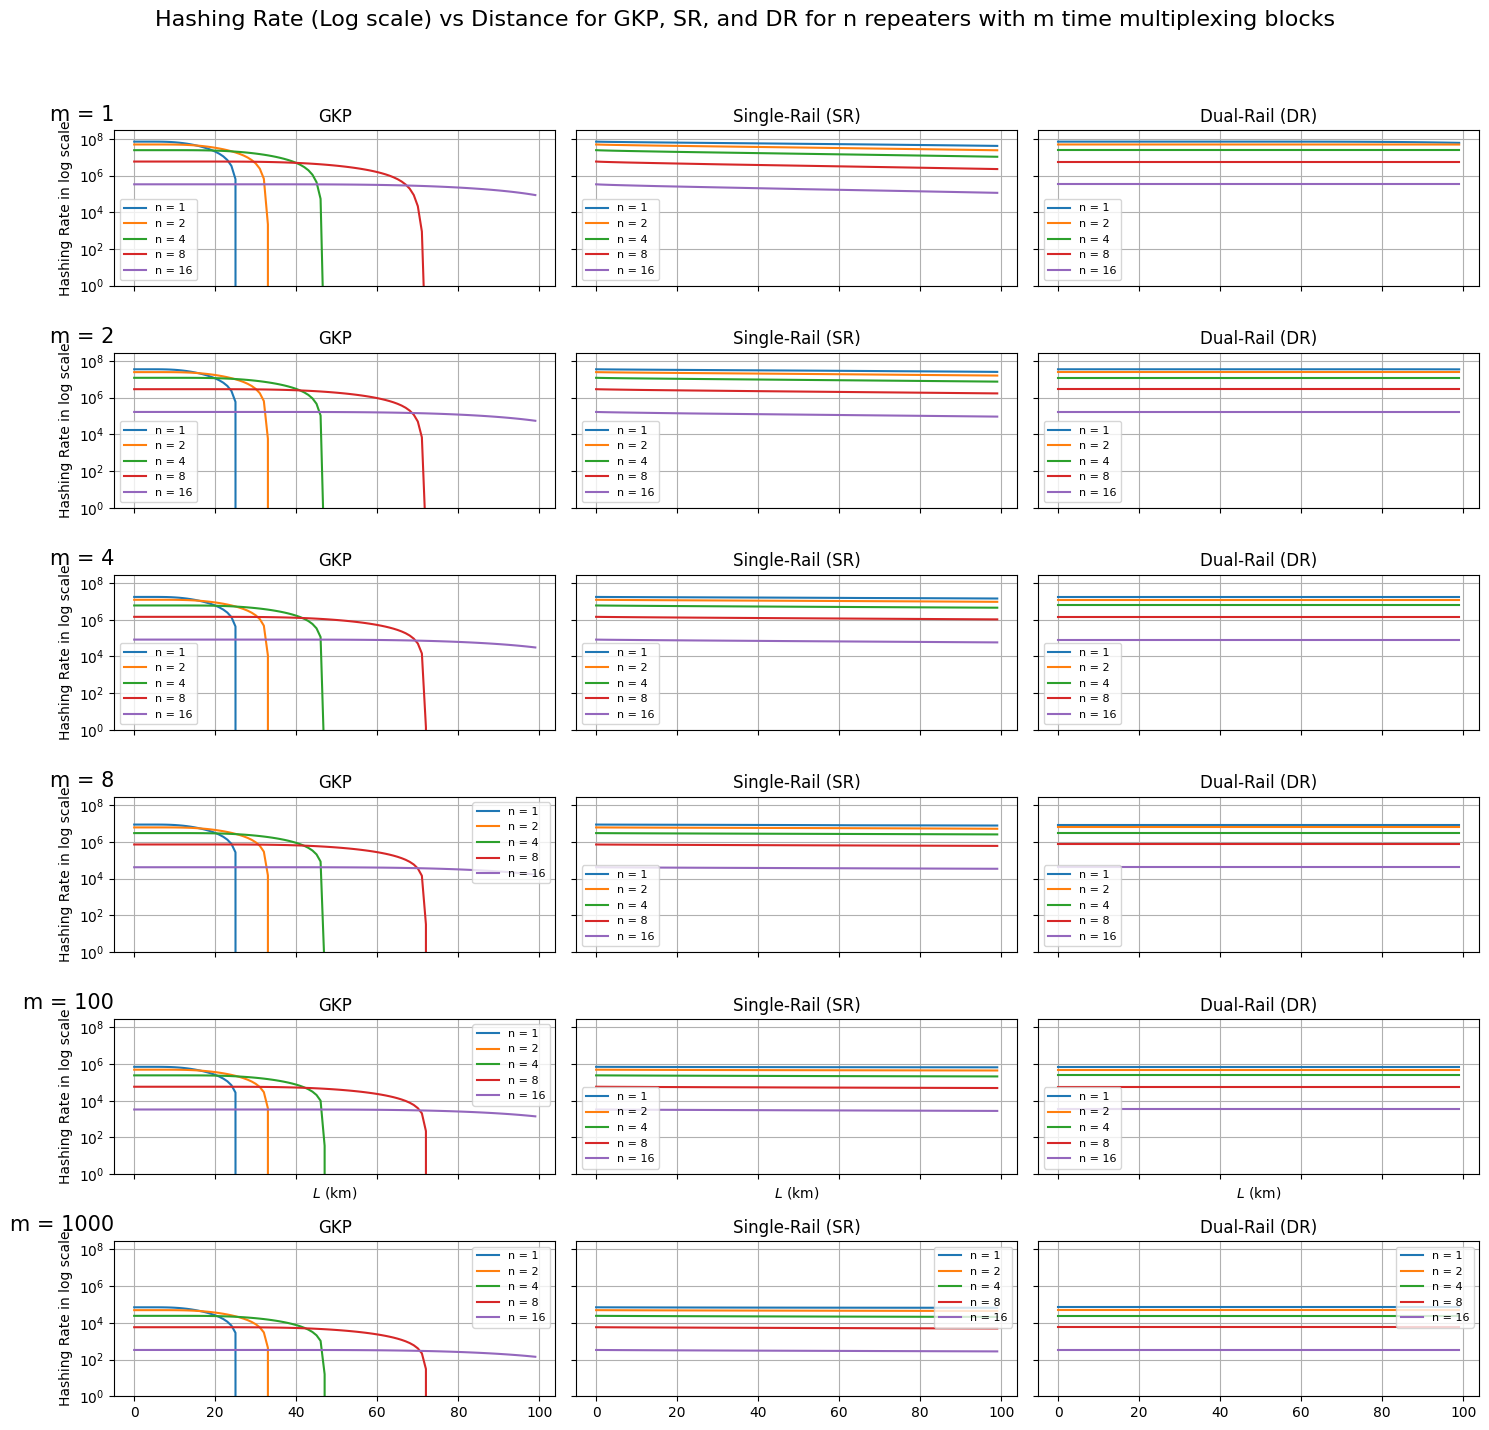

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

multi_n_data = [
    (1, Ls, [rates1, rates2, rates4, rates8, rates16],
        [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16],
        [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16]),
    (2, Ls, [m2rates1, m2rates2, m2rates4, m2rates8, m2rates16],
        [m2ratesSR1, m2ratesSR2, m2ratesSR4, m2ratesSR8, m2ratesSR16],
        [m2ratesDR1, m2ratesDR2, m2ratesDR4, m2ratesDR8, m2ratesDR16]),
    (4, Ls, [m4rates1, m4rates2, m4rates4, m4rates8, m4rates16],
        [m4ratesSR1, m4ratesSR2, m4ratesSR4, m4ratesSR8, m4ratesSR16],
        [m4ratesDR1, m4ratesDR2, m4ratesDR4, m4ratesDR8, m4ratesDR16]),
    (8, Ls, [m8rates1, m8rates2, m8rates4, m8rates8, m8rates16],
        [m8ratesSR1, m8ratesSR2, m8ratesSR4, m8ratesSR8, m8ratesSR16],
        [m8ratesDR1, m8ratesDR2, m8ratesDR4, m8ratesDR8, m8ratesDR16]),
    (100, Ls, [m100rates1, m100rates2, m100rates4, m100rates8, m100rates16],
         [m100ratesSR1, m100ratesSR2, m100ratesSR4, m100ratesSR8, m100ratesSR16],
         [m100ratesDR1, m100ratesDR2, m100ratesDR4, m100ratesDR8, m100ratesDR16]),
    (1000, Ls, [m1000rates1, m1000rates2, m1000rates4, m1000rates8, m1000rates16],
         [m1000ratesSR1, m1000ratesSR2, m1000ratesSR4, m1000ratesSR8, m1000ratesSR16],
         [m1000ratesDR1, m1000ratesDR2, m1000ratesDR4, m1000ratesDR8, m1000ratesDR16]),
]

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8

for row, (m, Ls, gkp_list, sr_list, dr_list) in enumerate(multi_n_data):
    # Annotate m value on the left of each row
    axes[row, 0].annotate(f"m = {m}", xy=(0.0, 1.1), xycoords="axes fraction",
                          fontsize=15, rotation=0, va="center", ha="right")

    # GKP
    for i, rate_curve in enumerate(gkp_list):
        n = n_vals[i]
        axes[row, 0].plot(Ls, rate_curve, label=f"n = {n}")
    axes[row, 0].set_title("GKP")
    axes[row, 0].set_yscale("log")

    # SR
    for i, rate_curve in enumerate(sr_list):
        axes[row, 1].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 1].set_title("Single-Rail (SR)")
    axes[row, 1].set_yscale("log")

    # DR
    for i, rate_curve in enumerate(dr_list):
        axes[row, 2].plot(Ls, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 2].set_title("Dual-Rail (DR)")
    axes[row, 2].set_yscale("log")

    for col in range(3):
        axes[row, col].grid(True)
        axes[row, col].legend(fontsize=8)
        axes[row, col].set_ylim(bottom=1)


        if row == 4:
            axes[row, col].set_xlabel("$L$ (km)")
        if col == 0:
            axes[row, col].set_ylabel("Hashing Rate in log scale")

fig.suptitle("Hashing Rate (Log scale) vs Distance for GKP, SR, and DR for n repeaters with m time multiplexing blocks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

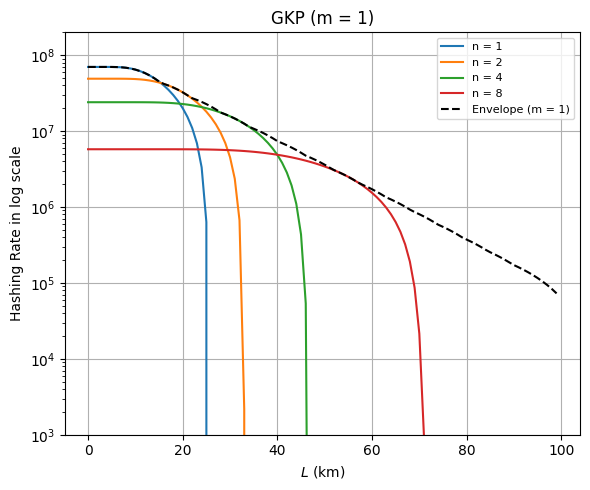

In [245]:
q = 0.7
tau = 1e-8
M = 50
alpha = (np.log(10) / 10) * 0.2

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_yscale("log")
ax.set_title("GKP (m = 1)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate in log scale")
ax.set_ylim(bottom=1e3, top=2e8)
ax.grid(True)

n_vals = [1, 2, 4, 8]

# Just m = 1 data
m = 1
Ls = np.array(Ls)  # ensure it's an array
gkp_list = [rates1, rates2, rates4, rates8]

color_cycle = plt.get_cmap("tab10")

for i, rate_curve in enumerate(gkp_list):
    n = n_vals[i]
    color = color_cycle(i)

    ax.plot(Ls, rate_curve, label=f"n = {n}", color=color)

n_scan_vals = np.arange(1, 16)

rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
        pc = Pc(sigma1, nu_opt, L, n)
        pf = Pf(sigma1, nu_opt, L, n)
        pSWAP = (pc + pf)**2
        pELEM = 1 - (1 - pSWAP)**(M * m)
        pNETWORK = pELEM**(n + 1) * q**n
        rate = pNETWORK / (tau * m)

        # Include hashing bound
        vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
        state_bound = hashing_bound(BSM_mixture_chain(vec))

        true_hashing_rate = rate * state_bound

        best_rate = max(best_rate , true_hashing_rate)
    rate_envelope.append(best_rate)

ax.plot(Ls, rate_envelope, color="black", linestyle="--", linewidth=1.5, label="Envelope (m = 1)")

ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

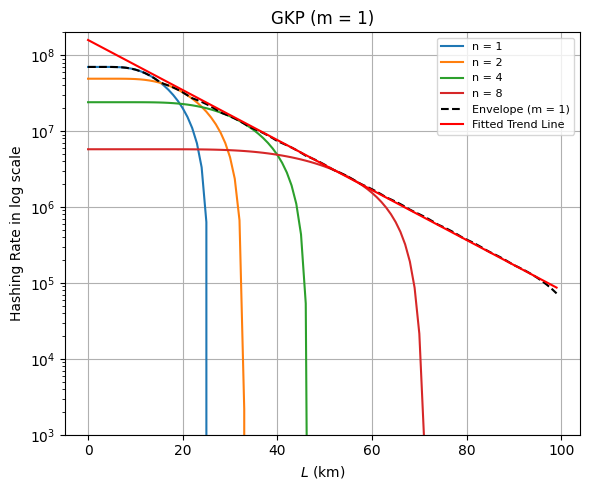

In [246]:
q = 0.7
tau = 1e-8
M = 50
alpha = (np.log(10) / 10) * 0.2

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_yscale("log")
ax.set_title("GKP (m = 1)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate in log scale")
ax.set_ylim(bottom=1e3, top=2e8)
ax.grid(True)

n_vals = [1, 2, 4, 8]

# Just m = 1 data
m = 1
Ls = np.array(Ls)  # ensure it's an array
gkp_list = [rates1, rates2, rates4, rates8]

color_cycle = plt.get_cmap("tab10")

for i, rate_curve in enumerate(gkp_list):
    n = n_vals[i]
    color = color_cycle(i)

    ax.plot(Ls, rate_curve, label=f"n = {n}", color=color)

n_scan_vals = np.arange(1, 16)

rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
        pc = Pc(sigma1, nu_opt, L, n)
        pf = Pf(sigma1, nu_opt, L, n)
        pSWAP = (pc + pf)**2
        pELEM = 1 - (1 - pSWAP)**(M * m)
        pNETWORK = pELEM**(n + 1) * q**n
        rate = pNETWORK / (tau * m)

        # Include hashing bound
        vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
        state_bound = hashing_bound(BSM_mixture_chain(vec))

        true_hashing_rate = rate * state_bound

        best_rate = max(best_rate , true_hashing_rate)
    rate_envelope.append(best_rate)

ax.plot(Ls, rate_envelope, color="black", linestyle="--", linewidth=1.5, label="Envelope (m = 1)")

log_env = np.log(rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

ax.plot(Ls, predicted_env, color="red", label="Fitted Trend Line")

ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

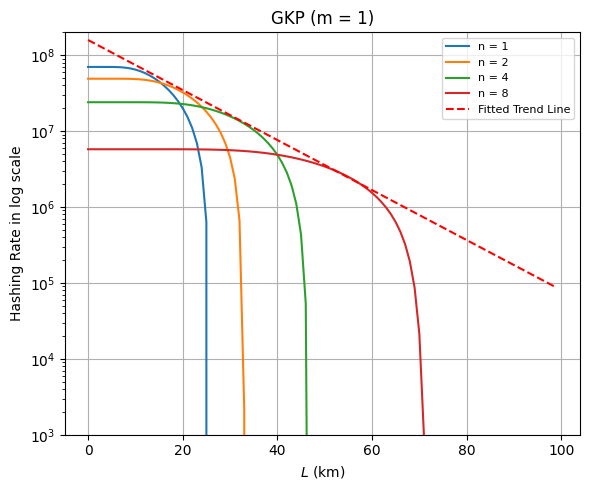

In [247]:
q = 0.7
tau = 1e-8
M = 50
alpha = (np.log(10) / 10) * 0.2

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_yscale("log")
ax.set_title("GKP (m = 1)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate in log scale")
ax.set_ylim(bottom=1e3, top=2e8)
ax.grid(True)

n_vals = [1, 2, 4, 8]

# Just m = 1 data
m = 1
Ls = np.array(Ls)  # ensure it's an array
gkp_list = [rates1, rates2, rates4, rates8]

color_cycle = plt.get_cmap("tab10")

for i, rate_curve in enumerate(gkp_list):
    n = n_vals[i]
    color = color_cycle(i)

    ax.plot(Ls, rate_curve, label=f"n = {n}", color=color)

n_scan_vals = np.arange(1, 16)

rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
        pc = Pc(sigma1, nu_opt, L, n)
        pf = Pf(sigma1, nu_opt, L, n)
        pSWAP = (pc + pf)**2
        pELEM = 1 - (1 - pSWAP)**(M * m)
        pNETWORK = pELEM**(n + 1) * q**n
        rate = pNETWORK / (tau * m)

        # Include hashing bound
        vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
        state_bound = hashing_bound(BSM_mixture_chain(vec))

        true_hashing_rate = rate * state_bound

        best_rate = max(best_rate , true_hashing_rate)
    rate_envelope.append(best_rate)

log_env = np.log(rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

ax.plot(Ls, predicted_env, color="red", linestyle = "--" , label="Fitted Trend Line")

ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


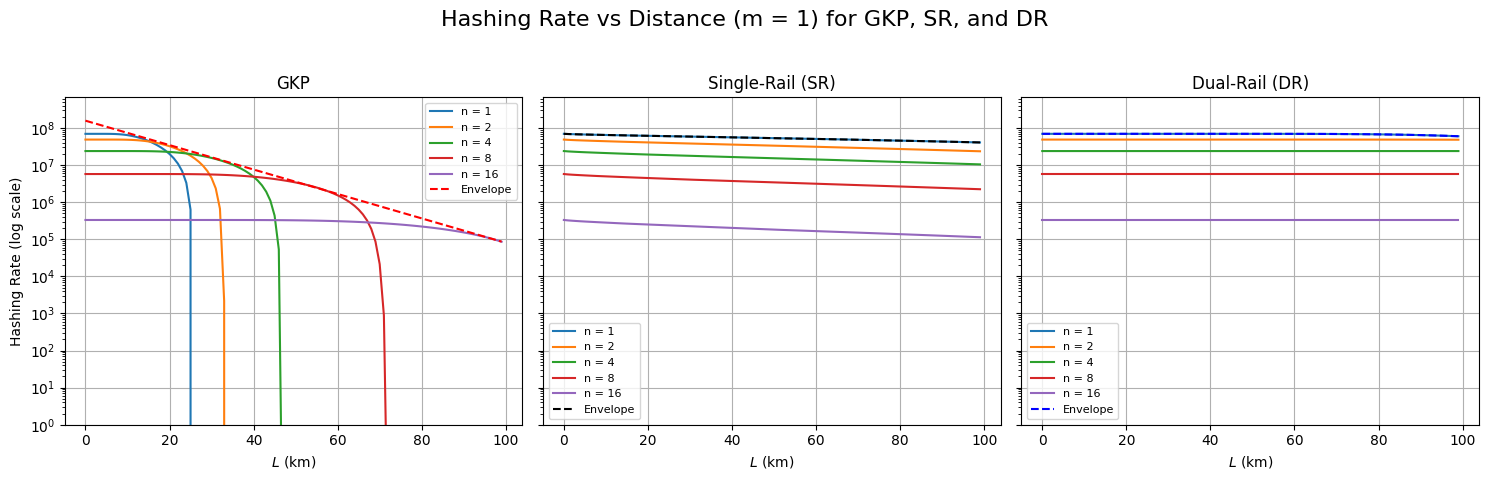

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [rates1, rates2, rates4, rates8, rates16]
sr_list = [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16]
dr_list = [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)

log_env = np.log(gkp_rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)



# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

# ---- Plot All ----
# GKP
for i, curve in enumerate(gkp_list):
    axes[0].plot(Ls, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[0].plot(Ls, predicted_env, color="red", linestyle = "--" , label="Envelope")
axes[0].set_title("GKP")
axes[0].set_yscale("log")
axes[0].grid(True)

# SR
for i, curve in enumerate(sr_list):
    axes[1].plot(Ls, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[1].plot(Ls, sr_rate_envelope, linestyle="--", color="black", label="Envelope")
axes[1].set_title("Single-Rail (SR)")
axes[1].set_yscale("log")
axes[1].grid(True)

# DR
for i, curve in enumerate(dr_list):
    axes[2].plot(Ls, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[2].plot(Ls, dr_rate_envelope, linestyle="--", color="blue", label="Envelope")
axes[2].set_title("Dual-Rail (DR)")
axes[2].set_yscale("log")
axes[2].grid(True)

# Axes formatting
for ax in axes:
    ax.set_ylim(bottom=1)
    ax.set_xlabel("$L$ (km)")
    ax.legend(fontsize=8)
axes[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Distance (m = 1) for GKP, SR, and DR", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
M = 10
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

Ls = np.arange(0 , 200 , 2)

multi_n_data = [
    (1, Ls, [rates1, rates2, rates4, rates8, rates16],
        [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16],
        [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16]),
    (2, Ls, [m2rates1, m2rates2, m2rates4, m2rates8, m2rates16],
        [m2ratesSR1, m2ratesSR2, m2ratesSR4, m2ratesSR8, m2ratesSR16],
        [m2ratesDR1, m2ratesDR2, m2ratesDR4, m2ratesDR8, m2ratesDR16]),
    (4, Ls, [m4rates1, m4rates2, m4rates4, m4rates8, m4rates16],
        [m4ratesSR1, m4ratesSR2, m4ratesSR4, m4ratesSR8, m4ratesSR16],
        [m4ratesDR1, m4ratesDR2, m4ratesDR4, m4ratesDR8, m4ratesDR16]),
    (8, Ls, [m8rates1, m8rates2, m8rates4, m8rates8, m8rates16],
        [m8ratesSR1, m8ratesSR2, m8ratesSR4, m8ratesSR8, m8ratesSR16],
        [m8ratesDR1, m8ratesDR2, m8ratesDR4, m8ratesDR8, m8ratesDR16]),
    (100, Ls, [m100rates1, m100rates2, m100rates4, m100rates8, m100rates16],
         [m100ratesSR1, m100ratesSR2, m100ratesSR4, m100ratesSR8, m100ratesSR16],
         [m100ratesDR1, m100ratesDR2, m100ratesDR4, m100ratesDR8, m100ratesDR16]),
    (1000, Ls, [m1000rates1, m1000rates2, m1000rates4, m1000rates8, m1000rates16],
         [m1000ratesSR1, m1000ratesSR2, m1000ratesSR4, m1000ratesSR8, m1000ratesSR16],
         [m1000ratesDR1, m1000ratesDR2, m1000ratesDR4, m1000ratesDR8, m1000ratesDR16]),
]

gkp_envelopes = []
sr_envelopes = []
dr_envelopes = []

for i, (m, Ls, gkp_list, sr_list, dr_list) in enumerate(multi_n_data):

    # ---- Compute GKP Envelope ----
    gkp_rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
                pc = Pc(sigma1, nu_opt, L, n)
                pf = Pf(sigma1, nu_opt, L, n)
                pSWAP = (pc + pf)**2
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)

                vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
                state_bound = hashing_bound(BSM_mixture_chain(vec))
                best_rate = max(best_rate, rate * state_bound)
            except Exception:
                continue
        gkp_rate_envelope.append(best_rate)
    

    gkp_rate_envelope = np.log(gkp_rate_envelope)
    valid_mask = (log_env > 0) & (Ls > 30)

    if np.any(valid_mask):
        slope, intercept, *_ = linregress(Ls[valid_mask], np.log(gkp_rate_envelope[valid_mask]))
        predicted_env = np.exp(slope * Ls + intercept)
    else:
        predicted_env = np.full_like(Ls, np.nan)

    gkp_envelopes.append((m, predicted_env))



    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))

            if np.isnan(rate) or np.isnan(state_bound):
                print(f"[NaN warning] L={L}, n={n}, m={m}, nu_opt={nu_opt}, rate={rate}, state_bound={state_bound}")
            
            best_rate = max(best_rate, rate * state_bound)

        except Exception as e:
            print(f"[Exception] L={L}, n={n}, m={m} → {e}")



    # ---- Compute SR Envelope ----
    sr_rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
                eta = new_eta(L, n)
                pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)
                state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
                best_rate = max(best_rate, rate * state_bound)
            except Exception:
                continue
        sr_rate_envelope.append(best_rate)

    sr_envelopes.append((m, sr_rate_envelope))

    # ---- Compute DR Envelope ----
    dr_rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                eta = new_eta(L, n)
                pSWAP = np.trace(DualRailState(eta, 0, 1))
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)
                if n == 1:
                    rho = QStateDual(eta, 0, 1)
                else:
                    vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                    rho = BSM_mixture_chain(vec)
                state_bound = hashing_bound(rho)
                best_rate = max(best_rate, rate * state_bound)
            except Exception:
                continue
        dr_rate_envelope.append(best_rate)

    dr_envelopes.append((m, dr_rate_envelope))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

for m, env in gkp_envelopes:
    axes[0].plot(Ls, env, label=f"m = {m}")
axes[0].set_title("GKP Envelopes")
axes[0].set_yscale("log")
axes[0].grid(True)
axes[0].legend(fontsize=8)

for m, env in sr_envelopes:
    axes[1].plot(Ls, env, label=f"m = {m}")
axes[1].set_title("SR Envelopes")
axes[1].set_yscale("log")
axes[1].grid(True)
axes[1].legend(fontsize=8)

for m, env in dr_envelopes:
    axes[2].plot(Ls, env, label=f"m = {m}")
axes[2].set_title("DR Envelopes")
axes[2].set_yscale("log")
axes[2].grid(True)
axes[2].legend(fontsize=8)

for ax in axes:
    ax.set_xlabel("$L$ (km)")
    ax.set_ylim(bottom=1)
axes[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate Envelopes for Various $m$ (Time Multiplexing Values) for $M=10$ (Space Multiplexing)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/2357910155.py:62: RuntimeWarning: divide by zero encountered in log
  gkp_rate_envelope = np.log(gkp_rate_envelope)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_21277/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


In [ ]:
m_scan_vals = np.unique(np.round(np.logspace(0, 3, 50)).astype(int))  # m = 1 to 1000

gkp_optimized_envelope = []

for L in Ls:
    best_rate_at_L = 0
    for m in m_scan_vals:
        for n in n_scan_vals:
            try:
                _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
                pc = Pc(sigma1, nu_opt, L, n)
                pf = Pf(sigma1, nu_opt, L, n)
                pSWAP = (pc + pf)**2
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)

                vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
                state_bound = hashing_bound(BSM_mixture_chain(vec))

                full_rate = rate * state_bound
                if not np.isnan(full_rate):
                    best_rate_at_L = max(best_rate_at_L, full_rate)
            except Exception:
                continue
    gkp_optimized_envelope.append(best_rate_at_L)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ls, gkp_optimized_envelope, label="Optimized over m", lw=2)
plt.yscale("log")
plt.xlabel("$L$ (km)")
plt.ylabel("Hashing Rate (log scale)")
plt.title("Subexponential Envelope Optimized over $m$")
plt.grid(True)
plt.legend()
plt.show()

In [309]:
M = 10
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

Ls = np.arange(0 , 2000 , 20)

multi_n_data = [
    (1, Ls, [rates1, rates2, rates4, rates8, rates16],
        [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16],
        [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16]),
    (2, Ls, [m2rates1, m2rates2, m2rates4, m2rates8, m2rates16],
        [m2ratesSR1, m2ratesSR2, m2ratesSR4, m2ratesSR8, m2ratesSR16],
        [m2ratesDR1, m2ratesDR2, m2ratesDR4, m2ratesDR8, m2ratesDR16]),
    (4, Ls, [m4rates1, m4rates2, m4rates4, m4rates8, m4rates16],
        [m4ratesSR1, m4ratesSR2, m4ratesSR4, m4ratesSR8, m4ratesSR16],
        [m4ratesDR1, m4ratesDR2, m4ratesDR4, m4ratesDR8, m4ratesDR16]),
    (8, Ls, [m8rates1, m8rates2, m8rates4, m8rates8, m8rates16],
        [m8ratesSR1, m8ratesSR2, m8ratesSR4, m8ratesSR8, m8ratesSR16],
        [m8ratesDR1, m8ratesDR2, m8ratesDR4, m8ratesDR8, m8ratesDR16]),
    (100, Ls, [m100rates1, m100rates2, m100rates4, m100rates8, m100rates16],
         [m100ratesSR1, m100ratesSR2, m100ratesSR4, m100ratesSR8, m100ratesSR16],
         [m100ratesDR1, m100ratesDR2, m100ratesDR4, m100ratesDR8, m100ratesDR16]),
    (1000, Ls, [m1000rates1, m1000rates2, m1000rates4, m1000rates8, m1000rates16],
         [m1000ratesSR1, m1000ratesSR2, m1000ratesSR4, m1000ratesSR8, m1000ratesSR16],
         [m1000ratesDR1, m1000ratesDR2, m1000ratesDR4, m1000ratesDR8, m1000ratesDR16]),
]

gkp_envelopes = []
sr_envelopes = []
dr_envelopes = []

for i, (m, Ls, gkp_list, sr_list, dr_list) in enumerate(multi_n_data):

    # ---- Compute GKP Envelope ----
    gkp_rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
                pc = Pc(sigma1, nu_opt, L, n)
                pf = Pf(sigma1, nu_opt, L, n)
                pSWAP = (pc + pf)**2
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)

                vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
                state_bound = hashing_bound(BSM_mixture_chain(vec))
                best_rate = max(best_rate, rate * state_bound)
            except Exception:
                continue
        gkp_rate_envelope.append(best_rate)

    # Convert to NumPy array for masking
    gkp_rate_envelope = np.array(gkp_rate_envelope)

    # Mask valid data for fitting (rate > 0 and L > 30)
    valid_mask = (gkp_rate_envelope > 0) & (Ls > 30)
    if np.sum(valid_mask) >= 2:
        log_env = np.log(gkp_rate_envelope[valid_mask])
        slope, intercept, *_ = linregress(Ls[valid_mask], log_env)
        predicted_env = np.exp(slope * Ls + intercept)
    else:
        print(f"[Warning] Not enough valid GKP data for m = {m}. Skipping fit.")
        predicted_env = np.zeros_like(Ls)

    gkp_envelopes.append((m, predicted_env))

        # ---- Compute SR Envelope ----
    sr_rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
                eta = new_eta(L, n)
                pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)
                state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
                best_rate = max(best_rate, rate * state_bound)
            except Exception:
                continue
        sr_rate_envelope.append(best_rate)

    sr_rate_envelope = np.array(sr_rate_envelope)
    valid_mask = (sr_rate_envelope > 0) & (Ls > 600) & (Ls < 1600)
    if np.sum(valid_mask) >= 2:
        log_env = np.log(sr_rate_envelope[valid_mask])
        slope, intercept, *_ = linregress(Ls[valid_mask], log_env)
        predicted_env = np.exp(slope * Ls + intercept)
    else:
        print(f"[Warning] Not enough valid SR data for m = {m}. Skipping fit.")
        predicted_env = np.zeros_like(Ls)

    sr_envelopes.append((m, predicted_env))

    # ---- Compute DR Envelope ----
    dr_rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                eta = new_eta(L, n)
                pSWAP = np.trace(DualRailState(eta, 0, 1))
                pELEM = 1 - (1 - pSWAP)**(M * m)
                pNETWORK = pELEM**(n + 1) * q**n
                rate = pNETWORK / (tau * m)
                if n == 1:
                    rho = QStateDual(eta, 0, 1)
                else:
                    vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                    rho = BSM_mixture_chain(vec)
                state_bound = hashing_bound(rho)
                best_rate = max(best_rate, rate * state_bound)
            except Exception:
                continue
        dr_rate_envelope.append(best_rate)

    dr_rate_envelope = np.array(dr_rate_envelope)
    valid_mask = (dr_rate_envelope > 0) & (Ls > 200) & (Ls < 1500)
    if np.sum(valid_mask) >= 2:
        log_env = np.log(dr_rate_envelope[valid_mask])
        slope, intercept, *_ = linregress(Ls[valid_mask], log_env)
        predicted_env = np.exp(slope * Ls + intercept)
    else:
        print(f"[Warning] Not enough valid DR data for m = {m}. Skipping fit.")
        predicted_env = np.zeros_like(Ls)

    dr_envelopes.append((m, predicted_env))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


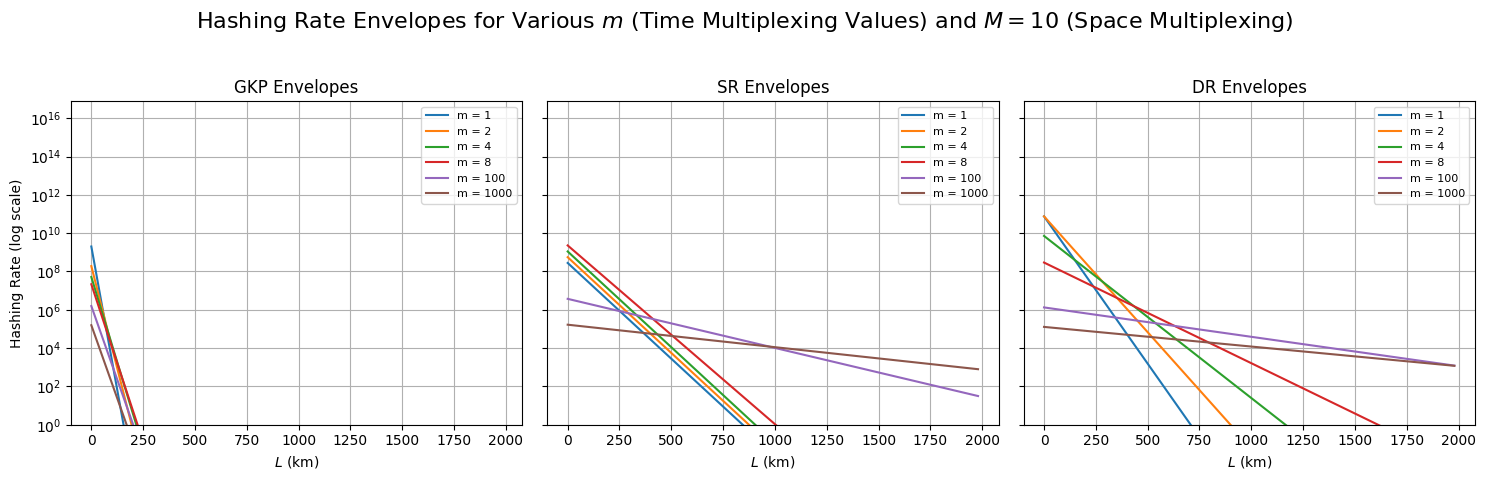

In [310]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

for m, env in gkp_envelopes:
    axes[0].plot(Ls, env, label=f"m = {m}")
axes[0].set_title("GKP Envelopes")
axes[0].set_yscale("log")
axes[0].grid(True)
axes[0].legend(fontsize=8)

for m, env in sr_envelopes:
    axes[1].plot(Ls, env, label=f"m = {m}")
axes[1].set_title("SR Envelopes")
axes[1].set_yscale("log")
axes[1].grid(True)
axes[1].legend(fontsize=8)

for m, env in dr_envelopes:
    axes[2].plot(Ls, env, label=f"m = {m}")
axes[2].set_title("DR Envelopes")
axes[2].set_yscale("log")
axes[2].grid(True)
axes[2].legend(fontsize=8)

for ax in axes:
    ax.set_xlabel("$L$ (km)")
    ax.set_ylim(bottom=1)
axes[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate Envelopes for Various $m$ (Time Multiplexing Values) and $M=10$ (Space Multiplexing)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


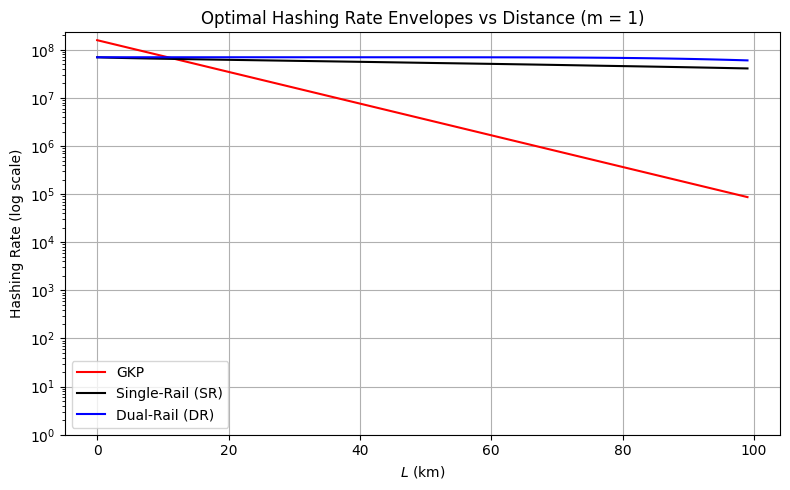

In [130]:
M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [rates1, rates2, rates4, rates8, rates16]
sr_list = [ratesSR1, ratesSR2, ratesSR4, ratesSR8, ratesSR16]
dr_list = [ratesDR1, ratesDR2, ratesDR4, ratesDR8, ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)

log_env = np.log(gkp_rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls, predicted_env, color="red" , label="GKP")
ax.plot(Ls, sr_rate_envelope, color="black", label="Single-Rail (SR)")
ax.plot(Ls, dr_rate_envelope, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 1)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(3e8)
ax.set_ylim(bottom=1)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


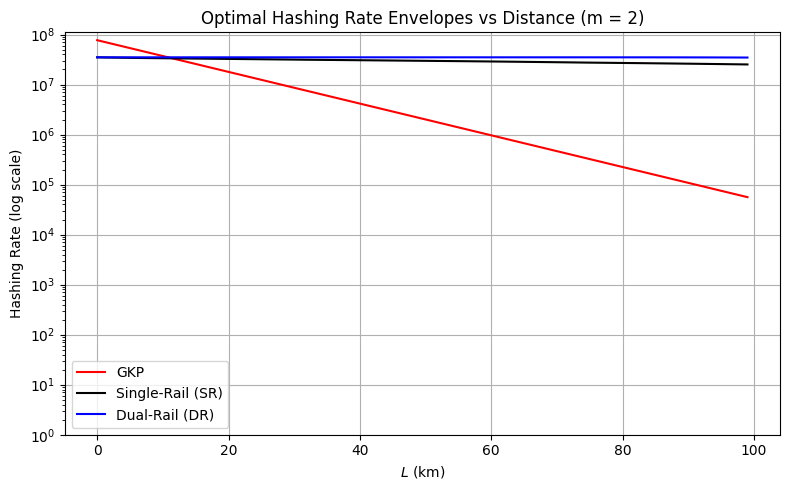

In [131]:
M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 2
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [m2rates1, m2rates2, m2rates4, m2rates8, m2rates16]
sr_list = [m2ratesSR1, m2ratesSR2, m2ratesSR4, m2ratesSR8, m2ratesSR16]
dr_list = [m2ratesDR1, m2ratesDR2, m2ratesDR4, m2ratesDR8, m2ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)

log_env = np.log(gkp_rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls, predicted_env, color="red" , label="GKP")
ax.plot(Ls, sr_rate_envelope, color="black", label="Single-Rail (SR)")
ax.plot(Ls, dr_rate_envelope, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 2)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(3e8)
ax.set_ylim(bottom=1)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


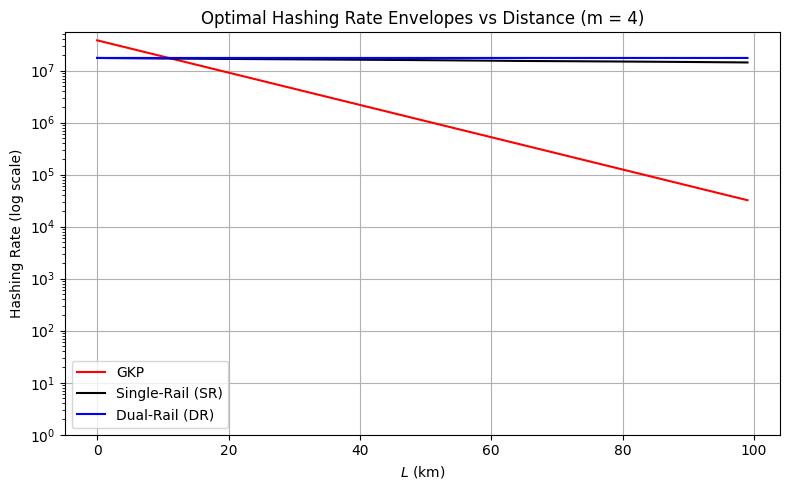

In [132]:
M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 4
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [m4rates1, m4rates2, m4rates4, m4rates8, m4rates16]
sr_list = [m4ratesSR1, m4ratesSR2, m4ratesSR4, m4ratesSR8, m4ratesSR16]
dr_list = [m4ratesDR1, m4ratesDR2, m4ratesDR4, m4ratesDR8, m4ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)

log_env = np.log(gkp_rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls, predicted_env, color="red" , label="GKP")
ax.plot(Ls, sr_rate_envelope, color="black", label="Single-Rail (SR)")
ax.plot(Ls, dr_rate_envelope, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 4)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(3e8)
ax.set_ylim(bottom=1)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


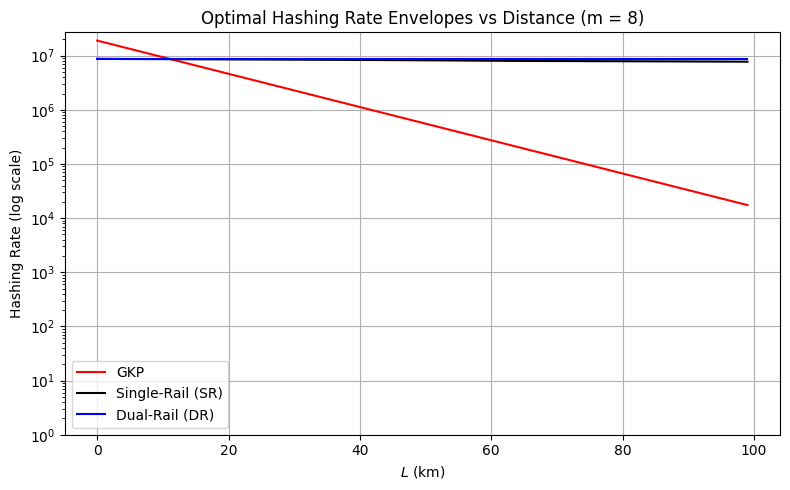

In [133]:
M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 8
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [m8rates1, m8rates2, m8rates4, m8rates8, m8rates16]
sr_list = [m8ratesSR1, m8ratesSR2, m8ratesSR4, m8ratesSR8, m8ratesSR16]
dr_list = [m8ratesDR1, m8ratesDR2, m8ratesDR4, m8ratesDR8, m8ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)

log_env = np.log(gkp_rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls, predicted_env, color="red" , label="GKP")
ax.plot(Ls, sr_rate_envelope, color="black", label="Single-Rail (SR)")
ax.plot(Ls, dr_rate_envelope, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 8)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(3e8)
ax.set_ylim(bottom=1)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


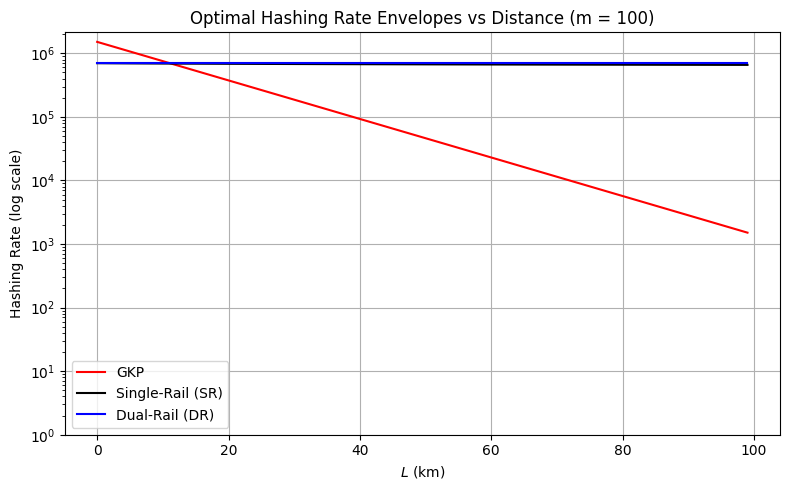

In [134]:
M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 100
n_scan_vals = np.arange(1, 16)
Ls = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [m100rates1, m100rates2, m100rates4, m100rates8, m100rates16]
sr_list = [m100ratesSR1, m100ratesSR2, m100ratesSR4, m100ratesSR8, m100ratesSR16]
dr_list = [m100ratesDR1, m100ratesDR2, m100ratesDR4, m100ratesDR8, m100ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)

log_env = np.log(gkp_rate_envelope)


fit_mask = Ls > 30
slope, intercept, *_ = linregress(Ls[fit_mask], log_env[fit_mask])
predicted_env = np.exp(slope * Ls + intercept)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls, predicted_env, color="red" , label="GKP")
ax.plot(Ls, sr_rate_envelope, color="black", label="Single-Rail (SR)")
ax.plot(Ls, dr_rate_envelope, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 100)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(3e8)
ax.set_ylim(bottom=1)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


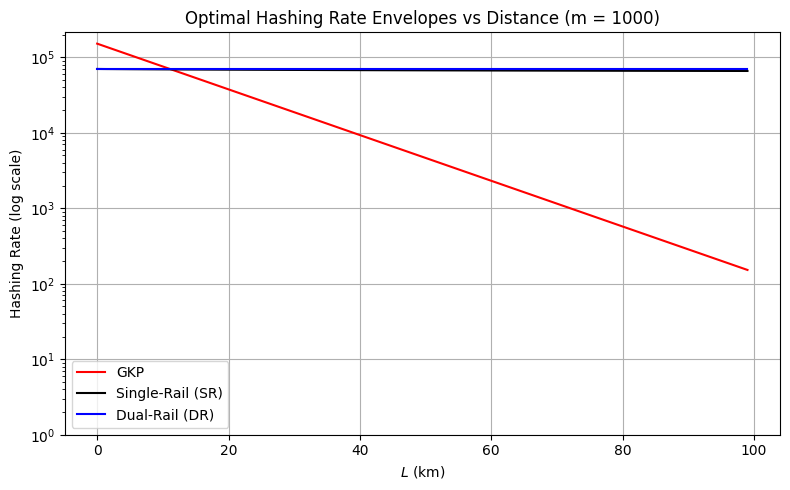

In [150]:
M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1000
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [m1000rates1, m1000rates2, m1000rates4, m1000rates8, m1000rates16]
sr_list = [m1000ratesSR1, m1000ratesSR2, m1000ratesSR4, m1000ratesSR8, m1000ratesSR16]
dr_list = [m1000ratesDR1, m1000ratesDR2, m1000ratesDR4, m1000ratesDR8, m1000ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls > 10)
fit_mask_sr = (Ls > 10) & (Ls < 90)
fit_mask_dr = (Ls > 10) & (Ls < 90)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls, predicted_env, color="red" , label="GKP")
ax.plot(Ls, sr_rate_envelope, color="black", label="Single-Rail (SR)")
ax.plot(Ls, dr_rate_envelope, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 1000)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(3e8)
ax.set_ylim(bottom=1)
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


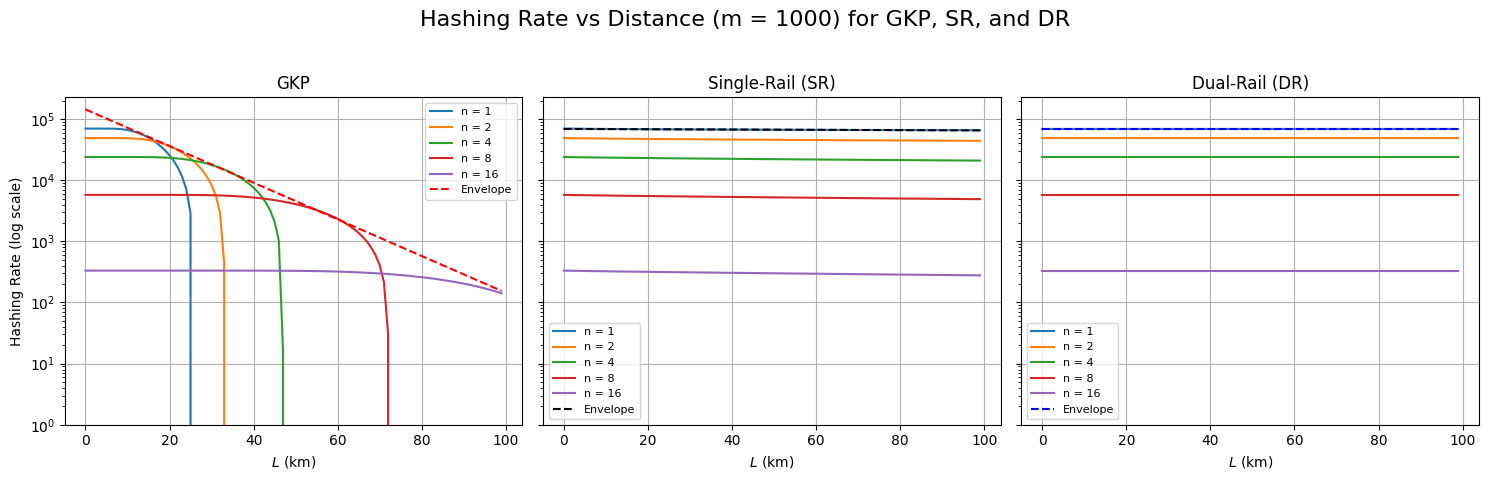

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1000
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls)
color_cycle = plt.get_cmap("tab10")

gkp_list = [m1000rates1, m1000rates2, m1000rates4, m1000rates8, m1000rates16]
sr_list = [m1000ratesSR1, m1000ratesSR2, m1000ratesSR4, m1000ratesSR8, m1000ratesSR16]
dr_list = [m1000ratesDR1, m1000ratesDR2, m1000ratesDR4, m1000ratesDR8, m1000ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls > 10)
fit_mask_sr = (Ls > 10) & (Ls < 90)
fit_mask_dr = (Ls > 10) & (Ls < 90)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls + intercept_dr)

# ---- Plot All ----
# GKP
for i, curve in enumerate(gkp_list):
    axes[0].plot(Ls, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[0].plot(Ls, predicted_gkp, linestyle = "--", color="red" , label="Envelope")
axes[0].set_title("GKP")
axes[0].set_yscale("log")
axes[0].grid(True)

# SR
for i, curve in enumerate(sr_list):
    axes[1].plot(Ls, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[1].plot(Ls, predicted_sr, linestyle="--", color="black", label="Envelope")
axes[1].set_title("Single-Rail (SR)")
axes[1].set_yscale("log")
axes[1].grid(True)

# DR
for i, curve in enumerate(dr_list):
    axes[2].plot(Ls, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[2].plot(Ls, predicted_dr, linestyle="--", color="blue", label="Envelope")
axes[2].set_title("Dual-Rail (DR)")
axes[2].set_yscale("log")
axes[2].grid(True)

# Axes formatting
for ax in axes:
    ax.set_ylim(bottom=1)
    ax.set_xlabel("$L$ (km)")
    ax.legend(fontsize=8)
axes[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Distance (m = 1000) for GKP, SR, and DR", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [119]:
plt.figure(dpi  = 1000)

Ls2 = np.arange(0 , 2000 , 20)

L2m1rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]


L2m1ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]
L2m1ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1)[0] for L in Ls2]


L2m1ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]
L2m1ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1) for L in Ls2]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [107]:
plt.figure(dpi  = 1000)

Ls2 = np.arange(0 , 2000 , 20)

L2m2rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]


L2m2ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]
L2m2ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 2)[0] for L in Ls2]


L2m2ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]
L2m2ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 2) for L in Ls2]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [108]:
plt.figure(dpi  = 1000)


L2m4rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]


L2m4ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]
L2m4ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 4)[0] for L in Ls2]


L2m4ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]
L2m4ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 4) for L in Ls2]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [109]:
plt.figure(dpi  = 1000)

L2m8rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]


L2m8ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]
L2m8ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 8)[0] for L in Ls2]


L2m8ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]
L2m8ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 8) for L in Ls2]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [110]:
plt.figure(dpi  = 1000)

L2m100rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]


L2m100ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]
L2m100ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 100)[0] for L in Ls2]


L2m100ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]
L2m100ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 100) for L in Ls2]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

In [111]:
plt.figure(dpi  = 1000)

L2m1000rates1 = [optimal_hashing_rate(sigma1 , L , 1 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates2 = [optimal_hashing_rate(sigma1 , L , 2 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates4 = [optimal_hashing_rate(sigma1 , L , 4 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates8 = [optimal_hashing_rate(sigma1 , L , 8 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates16 = [optimal_hashing_rate(sigma1 , L , 16 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates32 = [optimal_hashing_rate(sigma1 , L , 32 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates64 = [optimal_hashing_rate(sigma1 , L , 64 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000rates200 = [optimal_hashing_rate(sigma1 , L , 200 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]


L2m1000ratesSR1 = [optimal_SRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR2 = [optimal_SRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR4 = [optimal_SRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR8 = [optimal_SRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR16 = [optimal_SRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR32 = [optimal_SRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR64 = [optimal_SRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]
L2m1000ratesSR200 = [optimal_SRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1000)[0] for L in Ls2]


L2m1000ratesDR1 = [DRhashingrate(L , 1 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR2 = [DRhashingrate(L , 2 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR4 = [DRhashingrate(L , 4 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR8 = [DRhashingrate(L , 8 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR16 = [DRhashingrate(L , 16 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR32 = [DRhashingrate(L , 32 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR64 = [DRhashingrate(L , 64 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]
L2m1000ratesDR200 = [DRhashingrate(L , 200 , 50 , 0.7 , 1e-8 , 1000) for L in Ls2]

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


<Figure size 6400x4800 with 0 Axes>

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3991040769.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))


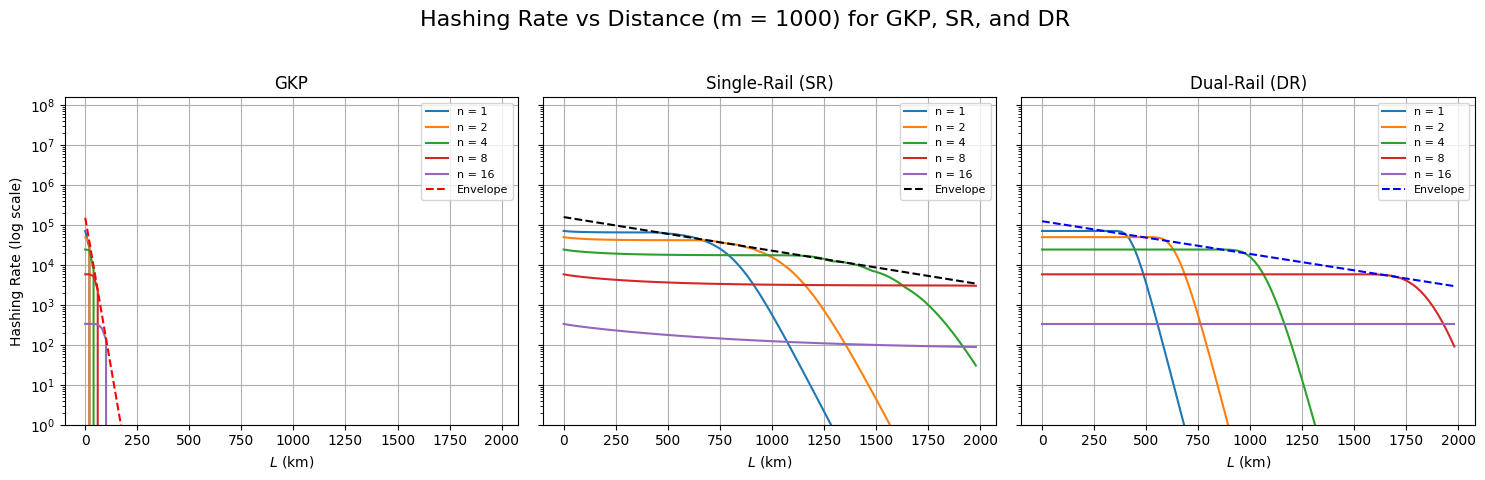

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1000
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m1000rates1, L2m1000rates2, L2m1000rates4, L2m1000rates8, L2m1000rates16]
sr_list = [L2m1000ratesSR1, L2m1000ratesSR2, L2m1000ratesSR4, L2m1000ratesSR8, L2m1000ratesSR16]
dr_list = [L2m1000ratesDR1, L2m1000ratesDR2, L2m1000ratesDR4, L2m1000ratesDR8, L2m1000ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 600) & (Ls2 < 1600)
fit_mask_dr = (Ls2 > 200) & (Ls2 < 1500)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# ---- Plot All ----
# GKP
for i, curve in enumerate(gkp_list):
    axes[0].plot(Ls2, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[0].plot(Ls2, predicted_gkp, linestyle = "--", color="red" , label="Envelope")
axes[0].set_title("GKP")
axes[0].set_yscale("log")
axes[0].grid(True)

# SR
for i, curve in enumerate(sr_list):
    axes[1].plot(Ls2, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[1].plot(Ls2, predicted_sr, linestyle="--", color="black", label="Envelope")
axes[1].set_title("Single-Rail (SR)")
axes[1].set_yscale("log")
axes[1].grid(True)

# DR
for i, curve in enumerate(dr_list):
    axes[2].plot(Ls2, curve, label=f"n = {n_vals[i]}", color=color_cycle(i))
axes[2].plot(Ls2, predicted_dr, linestyle="--", color="blue", label="Envelope")
axes[2].set_title("Dual-Rail (DR)")
axes[2].set_yscale("log")
axes[2].grid(True)

# Axes formatting
for ax in axes:
    ax.set_ylim(bottom=1)
    ax.set_xlabel("$L$ (km)")
    ax.legend(fontsize=8)
axes[0].set_ylabel("Hashing Rate (log scale)")

fig.suptitle("Hashing Rate vs Distance (m = 1000) for GKP, SR, and DR", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3171009635.py:83: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3492810186.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3492810186.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


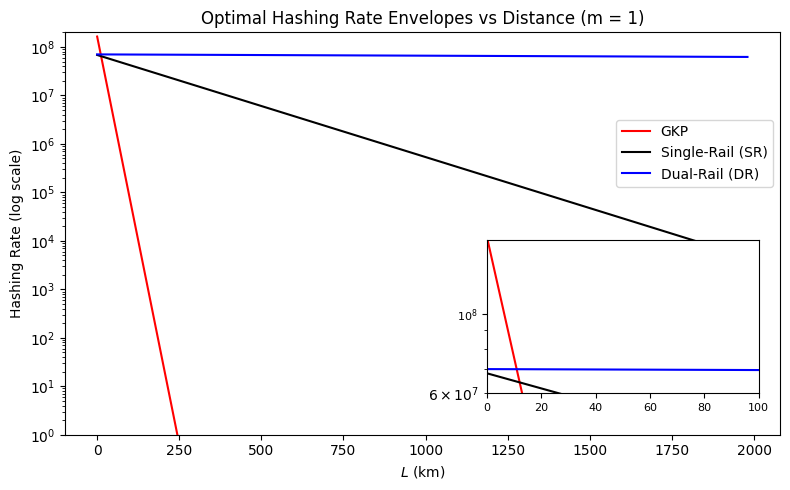

In [214]:
Ls2 = np.arange(0 , 2000 , 20)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m1rates1, L2m1rates2, L2m1rates4, L2m1rates8, L2m1rates16]
sr_list = [L2m1ratesSR1, L2m1ratesSR2, L2m1ratesSR4, L2m1ratesSR8, L2m1ratesSR16]
dr_list = [L2m1ratesDR1, L2m1ratesDR2, L2m1ratesDR4, L2m1ratesDR8, L2m1ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 10) & (Ls2 < 80)
fit_mask_dr = (Ls2 > 10) & (Ls2 < 80)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls2, predicted_gkp, color="red" , label="GKP")
ax.plot(Ls2, predicted_sr, color="black", label="Single-Rail (SR)")
ax.plot(Ls2, predicted_dr, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 1)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(1,2e8)

ax.legend(loc="upper right" , bbox_to_anchor=(1, 0.8))

# Restrict inset data to L <= 100 km
inset_mask = Ls2 <= 100
Ls2_inset = Ls2[inset_mask]
gkp_inset = predicted_gkp[inset_mask]
sr_inset = predicted_sr[inset_mask]
dr_inset = predicted_dr[inset_mask]

# Create inset axes: location and size relative to main axes
axins = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.03, -0.45, 0.95, 0.95),  bbox_transform=ax.transAxes)

# Plot same data into inset
axins.plot(Ls2_inset, gkp_inset, color="red")
axins.plot(Ls2_inset, sr_inset, color="black")
axins.plot(Ls2_inset, dr_inset, color="blue")

# Set zoom limits
axins.set_ylim(6e7, 1.6e8)
axins.set_xlim(0, 100)  # Adjust if you want to focus on a specific L-range
axins.set_yscale("log")

axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1479141300.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1479141300.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


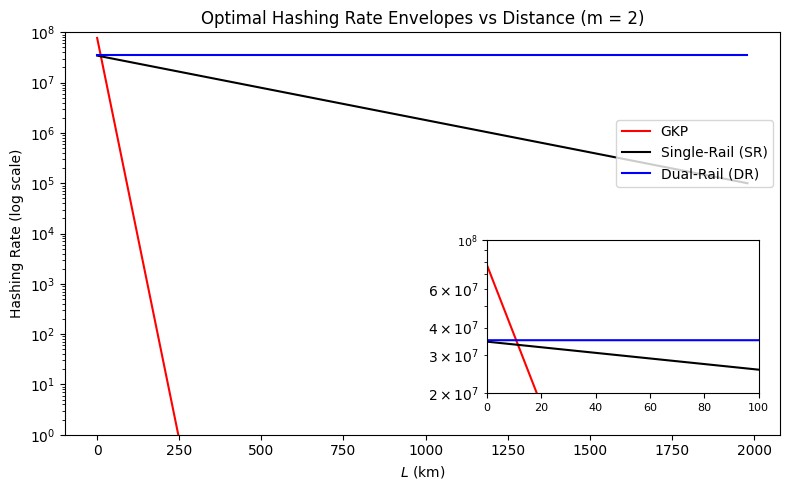

In [215]:
Ls2 = np.arange(0 , 2000 , 20)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 2
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m2rates1, L2m2rates2, L2m2rates4, L2m2rates8, L2m2rates16]
sr_list = [L2m2ratesSR1, L2m2ratesSR2, L2m2ratesSR4, L2m2ratesSR8, L2m2ratesSR16]
dr_list = [L2m2ratesDR1, L2m2ratesDR2, L2m2ratesDR4, L2m2ratesDR8, L2m2ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 10) & (Ls2 < 80)
fit_mask_dr = (Ls2 > 10) & (Ls2 < 80)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls2, predicted_gkp, color="red" , label="GKP")
ax.plot(Ls2, predicted_sr, color="black", label="Single-Rail (SR)")
ax.plot(Ls2, predicted_dr, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 2)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(1 , 1e8)

ax.legend(loc="upper right" , bbox_to_anchor=(1, 0.8))

# Restrict inset data to L <= 100 km
inset_mask = Ls2 <= 100
Ls2_inset = Ls2[inset_mask]
gkp_inset = predicted_gkp[inset_mask]
sr_inset = predicted_sr[inset_mask]
dr_inset = predicted_dr[inset_mask]

# Create inset axes: location and size relative to main axes
axins = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.03, -0.45, 0.95, 0.95),  bbox_transform=ax.transAxes)

# Plot same data into inset
axins.plot(Ls2_inset, gkp_inset, color="red")
axins.plot(Ls2_inset, sr_inset, color="black")
axins.plot(Ls2_inset, dr_inset, color="blue")

# Set zoom limits
axins.set_ylim(2e7, 1e8)
axins.set_xlim(0, 100)  # Adjust if you want to focus on a specific L-range
axins.set_yscale("log")

axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3334454776.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3334454776.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


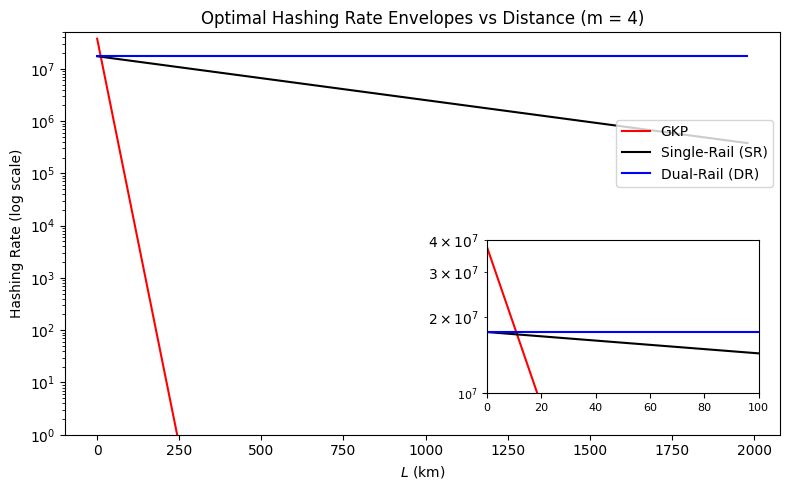

In [216]:
Ls2 = np.arange(0 , 2000 , 20)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 4
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m4rates1, L2m4rates2, L2m4rates4, L2m4rates8, L2m4rates16]
sr_list = [L2m4ratesSR1, L2m4ratesSR2, L2m4ratesSR4, L2m4ratesSR8, L2m4ratesSR16]
dr_list = [L2m4ratesDR1, L2m4ratesDR2, L2m4ratesDR4, L2m4ratesDR8, L2m4ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 10) & (Ls2 < 80)
fit_mask_dr = (Ls2 > 10) & (Ls2 < 80)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls2, predicted_gkp, color="red" , label="GKP")
ax.plot(Ls2, predicted_sr, color="black", label="Single-Rail (SR)")
ax.plot(Ls2, predicted_dr, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 4)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(1,5e7)

ax.legend(loc="upper right" , bbox_to_anchor=(1, 0.8))

# Restrict inset data to L <= 100 km
inset_mask = Ls2 <= 100
Ls2_inset = Ls2[inset_mask]
gkp_inset = predicted_gkp[inset_mask]
sr_inset = predicted_sr[inset_mask]
dr_inset = predicted_dr[inset_mask]

# Create inset axes: location and size relative to main axes
axins = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.03, -0.45, 0.95, 0.95),  bbox_transform=ax.transAxes)

# Plot same data into inset
axins.plot(Ls2_inset, gkp_inset, color="red")
axins.plot(Ls2_inset, sr_inset, color="black")
axins.plot(Ls2_inset, dr_inset, color="blue")

# Set zoom limits
axins.set_ylim(1e7,4e7)
axins.set_xlim(0, 100)  # Adjust if you want to focus on a specific L-range
axins.set_yscale("log")

axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1398964326.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1398964326.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


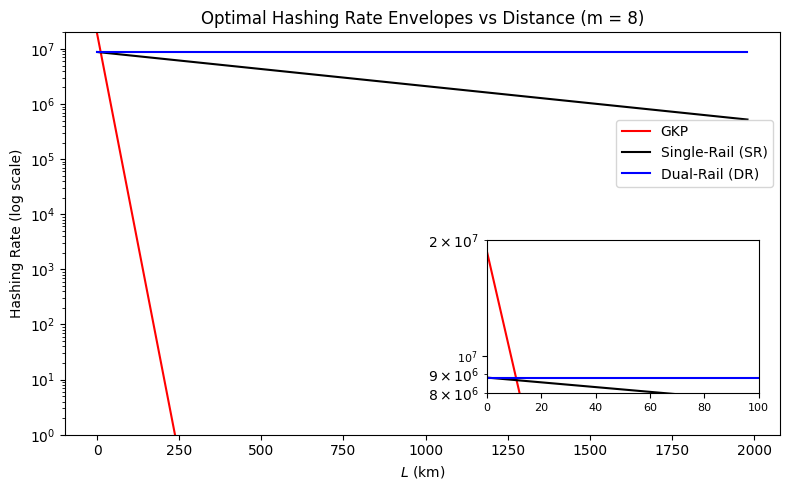

In [217]:
Ls2 = np.arange(0 , 2000 , 20)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 8
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m8rates1, L2m8rates2, L2m8rates4, L2m8rates8, L2m8rates16]
sr_list = [L2m8ratesSR1, L2m8ratesSR2, L2m8ratesSR4, L2m8ratesSR8, L2m8ratesSR16]
dr_list = [L2m8ratesDR1, L2m8ratesDR2, L2m8ratesDR4, L2m8ratesDR8, L2m8ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 10) & (Ls2 < 80)
fit_mask_dr = (Ls2 > 10) & (Ls2 < 80)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls2, predicted_gkp, color="red" , label="GKP")
ax.plot(Ls2, predicted_sr, color="black", label="Single-Rail (SR)")
ax.plot(Ls2, predicted_dr, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 8)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(1 , 2e7)

ax.legend(loc="upper right" , bbox_to_anchor=(1, 0.8))

# Restrict inset data to L <= 100 km
inset_mask = Ls2 <= 100
Ls2_inset = Ls2[inset_mask]
gkp_inset = predicted_gkp[inset_mask]
sr_inset = predicted_sr[inset_mask]
dr_inset = predicted_dr[inset_mask]

# Create inset axes: location and size relative to main axes
axins = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.03, -0.45, 0.95, 0.95),  bbox_transform=ax.transAxes)

# Plot same data into inset
axins.plot(Ls2_inset, gkp_inset, color="red")
axins.plot(Ls2_inset, sr_inset, color="black")
axins.plot(Ls2_inset, dr_inset, color="blue")

# Set zoom limits
axins.set_ylim(8e6, 2e7)
axins.set_xlim(0, 100)  # Adjust if you want to focus on a specific L-range
axins.set_yscale("log")

axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3770933047.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/3770933047.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


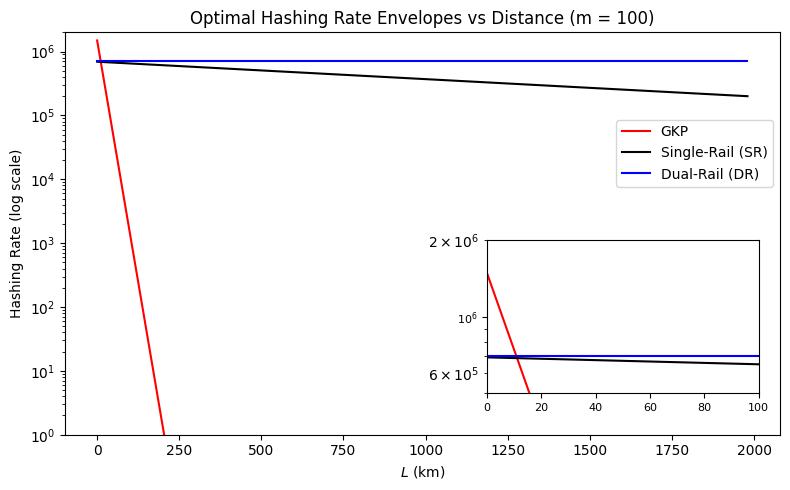

In [218]:
Ls2 = np.arange(0 , 2000 , 20)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 100
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m100rates1, L2m100rates2, L2m100rates4, L2m100rates8, L2m100rates16]
sr_list = [L2m100ratesSR1, L2m100ratesSR2, L2m100ratesSR4, L2m100ratesSR8, L2m100ratesSR16]
dr_list = [L2m100ratesDR1, L2m100ratesDR2, L2m100ratesDR4, L2m100ratesDR8, L2m100ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 10) & (Ls2 < 80)
fit_mask_dr = (Ls2 > 10) & (Ls2 < 80)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls2, predicted_gkp, color="red" , label="GKP")
ax.plot(Ls2, predicted_sr, color="black", label="Single-Rail (SR)")
ax.plot(Ls2, predicted_dr, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 100)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(1 , 2e6)

ax.legend(loc="upper right" , bbox_to_anchor=(1, 0.8))

# Restrict inset data to L <= 100 km
inset_mask = Ls2 <= 100
Ls2_inset = Ls2[inset_mask]
gkp_inset = predicted_gkp[inset_mask]
sr_inset = predicted_sr[inset_mask]
dr_inset = predicted_dr[inset_mask]

# Create inset axes: location and size relative to main axes
axins = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.03, -0.45, 0.95, 0.95),  bbox_transform=ax.transAxes)

# Plot same data into inset
axins.plot(Ls2_inset, gkp_inset, color="red")
axins.plot(Ls2_inset, sr_inset, color="black")
axins.plot(Ls2_inset, dr_inset, color="blue")

# Set zoom limits
axins.set_ylim(5e5,2e6)
axins.set_xlim(0, 100)  # Adjust if you want to focus on a specific L-range
axins.set_yscale("log")

axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1648207084.py:85: RuntimeWarning: divide by zero encountered in log
  log_env_gkp = np.log(np.array(gkp_rate_envelope))
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_16585/1648207084.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


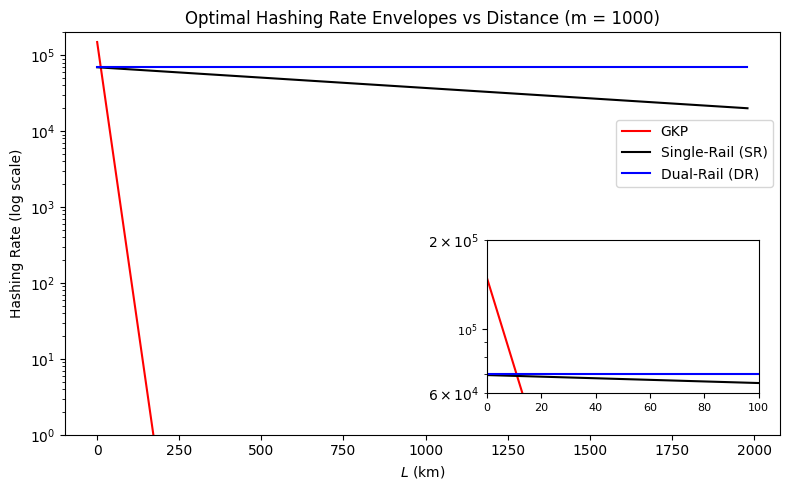

In [221]:
Ls2 = np.arange(0 , 2000 , 20)

M = 50
alpha_dB_per_km = 0.2
alpha = (alpha_dB_per_km / 10) * np.log(10)
n_vals = [1, 2, 4, 8, 16]
q = 0.7
tau = 1e-8
m = 1000
n_scan_vals = np.arange(1, 16)
Ls2 = np.array(Ls2)
color_cycle = plt.get_cmap("tab10")

gkp_list = [L2m1000rates1, L2m1000rates2, L2m1000rates4, L2m1000rates8, L2m1000rates16]
sr_list = [L2m1000ratesSR1, L2m1000ratesSR2, L2m1000ratesSR4, L2m1000ratesSR8, L2m1000ratesSR16]
dr_list = [L2m1000ratesDR1, L2m1000ratesDR2, L2m1000ratesDR4, L2m1000ratesDR8, L2m1000ratesDR16]

# ---- Compute GKP Envelope ----
gkp_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, nu_opt = optimal_hashing_rate(sigma1, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma1, nu_opt, L, n)
            pf = Pf(sigma1, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma1, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    gkp_rate_envelope.append(best_rate)
gkp_array = np.array(gkp_rate_envelope)

# ---- Compute SR Envelope ----
sr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = new_eta(L, n)
            pSWAP = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            state_bound = hashing_bound(SRchainState(L, gamma_opt, n))
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    sr_rate_envelope.append(best_rate)

# ---- Compute DR Envelope ----
dr_rate_envelope = []
for L in Ls2:
    best_rate = 0
    for n in n_scan_vals:
        try:
            eta = new_eta(L, n)
            pSWAP = np.trace(DualRailState(eta, 0, 1))
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)
            if n == 1:
                rho = QStateDual(eta, 0, 1)
            else:
                vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta, 0, 1)), n - 1)
                rho = BSM_mixture_chain(vec)
            state_bound = hashing_bound(rho)
            best_rate = max(best_rate, rate * state_bound)
        except Exception:
            continue
    dr_rate_envelope.append(best_rate)

fit_mask_gkp = (gkp_array > 1e-10) & (Ls2 > 10)
fit_mask_sr = (Ls2 > 10) & (Ls2 < 80)
fit_mask_dr = (Ls2 > 10) & (Ls2 < 80)

# GKP maximised envelope
log_env_gkp = np.log(np.array(gkp_rate_envelope))
slope_gkp, intercept_gkp, *_ = linregress(Ls2[fit_mask_gkp], log_env_gkp[fit_mask_gkp])
predicted_gkp = np.exp(slope_gkp * Ls2 + intercept_gkp)
# SR maximised envelope
log_env_sr = np.log(np.array(sr_rate_envelope))
slope_sr, intercept_sr, *_ = linregress(Ls2[fit_mask_sr], log_env_sr[fit_mask_sr])
predicted_sr = np.exp(slope_sr * Ls2 + intercept_sr)
# DR maximised envelope
log_env_dr = np.log(np.array(dr_rate_envelope))
slope_dr, intercept_dr, *_ = linregress(Ls2[fit_mask_dr], log_env_dr[fit_mask_dr])
predicted_dr = np.exp(slope_dr * Ls2 + intercept_dr)

# Now plot all three envelopes on a single plot
fig, ax = plt.subplots(figsize=(8, 5))

colors = plt.get_cmap("tab10")

ax.plot(Ls2, predicted_gkp, color="red" , label="GKP")
ax.plot(Ls2, predicted_sr, color="black", label="Single-Rail (SR)")
ax.plot(Ls2, predicted_dr, color="blue", label="Dual-Rail (DR)")

ax.set_title("Optimal Hashing Rate Envelopes vs Distance (m = 1000)")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate (log scale)")
ax.set_yscale("log")
ax.set_ylim(1 , 2e5)

ax.legend(loc="upper right" , bbox_to_anchor=(1, 0.8))

# Restrict inset data to L <= 100 km
inset_mask = Ls2 <= 100
Ls2_inset = Ls2[inset_mask]
gkp_inset = predicted_gkp[inset_mask]
sr_inset = predicted_sr[inset_mask]
dr_inset = predicted_dr[inset_mask]

# Create inset axes: location and size relative to main axes
axins = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(0.03, -0.45, 0.95, 0.95),  bbox_transform=ax.transAxes)

# Plot same data into inset
axins.plot(Ls2_inset, gkp_inset, color="red")
axins.plot(Ls2_inset, sr_inset, color="black")
axins.plot(Ls2_inset, dr_inset, color="blue")

# Set zoom limits
axins.set_ylim(6e4, 2e5)
axins.set_xlim(0, 100)  # Adjust if you want to focus on a specific L-range
axins.set_yscale("log")

axins.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

In [230]:
# Define the range of distances
Ls = np.arange(0, 2000.01, 1)

# Placeholder for different m values (time multiplexing values)
m_values = [1, 2, 4, 8, 100, 1000]

# For demonstration, we'll generate synthetic GKP, SR, and DR data
# Replace these with actual rates for given m
def generate_mock_rates(base_rate, decay_factor, m):
    return base_rate * np.exp(-decay_factor * Ls) / m

# Storage for intersection distances
intersection_points_sr = []
intersection_points_dr = []

for m in m_values:
    gkp = [L2m1000rates1, L2m1000rates2, L2m1000rates4, L2m1000rates8, L2m1000rates16]
    sr = [L2m1000ratesSR1, L2m1000ratesSR2, L2m1000ratesSR4, L2m1000ratesSR8, L2m1000ratesSR16]
    dr = [L2m1000ratesDR1, L2m1000ratesDR2, L2m1000ratesDR4, L2m1000ratesDR8, L2m1000ratesDR16]

    diff_sr = gkp - sr
    diff_dr = gkp - dr

    cross_idx_sr = np.where(np.diff(np.sign(diff_sr)))[0]
    cross_idx_dr = np.where(np.diff(np.sign(diff_dr)))[0]

    if len(cross_idx_sr) > 0:
        idx = cross_idx_sr[0]
        x0, x1 = Ls[idx], Ls[idx + 1]
        y0, y1 = diff_sr[idx], diff_sr[idx + 1]
        intersection_L_sr = x0 - y0 * (x1 - x0) / (y1 - y0)
    else:
        intersection_L_sr = np.nan

    if len(cross_idx_dr) > 0:
        idx = cross_idx_dr[0]
        x0, x1 = Ls[idx], Ls[idx + 1]
        y0, y1 = diff_dr[idx], diff_dr[idx + 1]
        intersection_L_dr = x0 - y0 * (x1 - x0) / (y1 - y0)
    else:
        intersection_L_dr = np.nan

    intersection_points_sr.append(intersection_L_sr)
    intersection_points_dr.append(intersection_L_dr)

# Prepare results as a DataFrame
df = pd.DataFrame({
    'm (multiplexing)': m_values,
    'Intersection GKP ∩ SR (km)': intersection_points_sr,
    'Intersection GKP ∩ DR (km)': intersection_points_dr
})

print(df.to_string(index=False))
print(f"m = {m}, min(diff_sr) = {np.min(diff_sr):.2f}, max(diff_sr) = {np.max(diff_sr):.2f}")

TypeError: unsupported operand type(s) for -: 'list' and 'list'

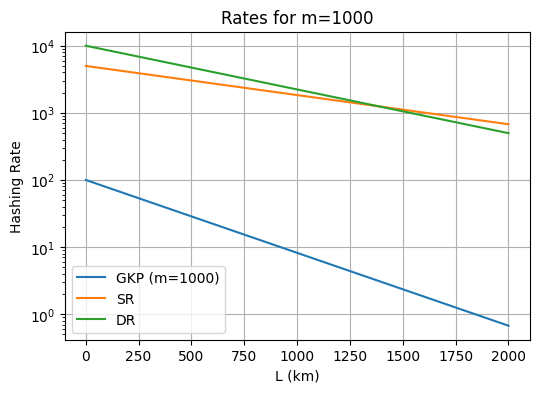

In [229]:
plt.figure(figsize=(6, 4))
plt.plot(Ls, gkp, label="GKP (m=1000)")
plt.plot(Ls, sr, label="SR")
plt.plot(Ls, dr, label="DR")
plt.yscale("log")
plt.xlabel("L (km)")
plt.ylabel("Hashing Rate")
plt.legend()
plt.grid(True)
plt.title("Rates for m=1000")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)
/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_6178/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


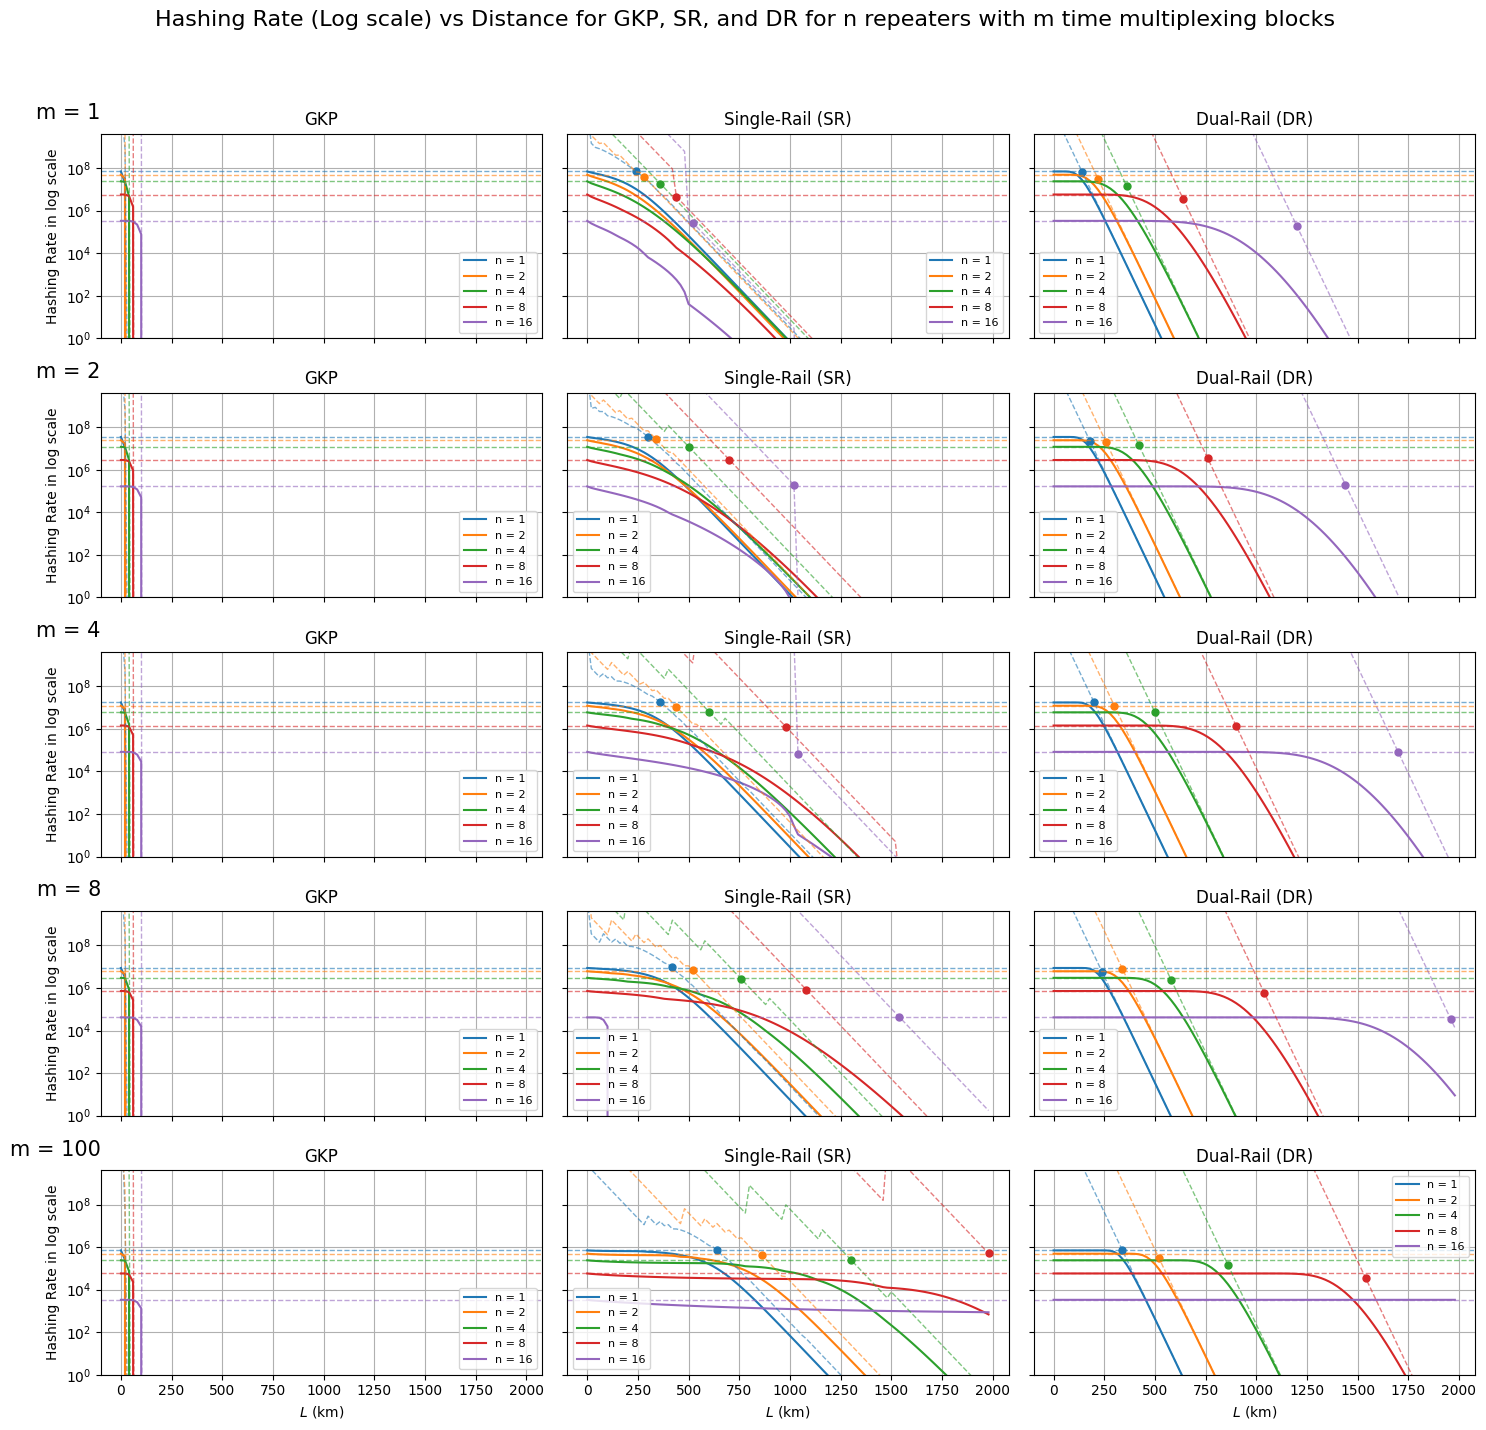

In [42]:
q = 0.7
tau = 1e-8
M = 50

alpha = (np.log(10) / 10) * 0.2


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.2)

multi_n_data = [
    (1 , Ls2, [L2m1rates1 , L2m1rates2 , L2m1rates4 , L2m1rates8 , L2m1rates16],
        [L2m1ratesSR1 , L2m1ratesSR2 , L2m1ratesSR4 , L2m1ratesSR8 , L2m1ratesSR16],
        [L2m1ratesDR1 , L2m1ratesDR2 , L2m1ratesDR4 , L2m1ratesDR8 , L2m1ratesDR16]),
    (2 , Ls2 , [L2m2rates1 , L2m2rates2 , L2m2rates4 , L2m2rates8 , L2m2rates16],
        [L2m2ratesSR1 , L2m2ratesSR2 , L2m2ratesSR4 , L2m2ratesSR8 , L2m2ratesSR16],
        [L2m2ratesDR1 , L2m2ratesDR2 , L2m2ratesDR4 , L2m2ratesDR8 , L2m2ratesDR16]),
    (4 , Ls2 , [L2m4rates1 , L2m4rates2 , L2m4rates4 , L2m4rates8 , L2m4rates16],
        [L2m4ratesSR1 , L2m4ratesSR2 , L2m4ratesSR4 , L2m4ratesSR8 , L2m4ratesSR16],
        [L2m4ratesDR1 , L2m4ratesDR2 , L2m4ratesDR4 , L2m4ratesDR8 , L2m4ratesDR16]),
    (8 , Ls2 , [L2m8rates1 , L2m8rates2 , L2m8rates4 , L2m8rates8 , L2m8rates16],
        [L2m8ratesSR1 , L2m8ratesSR2 , L2m8ratesSR4 , L2m8ratesSR8 , L2m8rates16],
        [L2m8ratesDR1 , L2m8ratesDR2 , L2m8ratesDR4 , L2m8ratesDR8 , L2m8ratesDR16]),
    (100 , Ls2 , [L2m100rates1 , L2m100rates2 , L2m100rates4 , L2m100rates8 , L2m100rates16],
         [L2m100ratesSR1, L2m100ratesSR2, L2m100ratesSR4 , L2m100ratesSR8 , L2m100ratesSR16],
         [L2m100ratesDR1, L2m100ratesDR2, L2m100ratesDR4 , L2m100ratesDR8 , L2m100ratesDR16]),
]

n_vals = [1, 2, 4 , 8 , 16]

for row, (m, Ls2, gkp_list, sr_list, dr_list) in enumerate(multi_n_data):
    # Annotate m value on the left of each row
    axes[row, 0].annotate(f"m = {m}", xy=(0.0, 1.1), xycoords="axes fraction",
                          fontsize=15, rotation=0, va="center", ha="right")

    # GKP
    for i, rate_curve in enumerate(gkp_list):
        axes[row, 0].plot(Ls2, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 0].set_title("GKP")
    axes[row, 0].set_yscale("log")

    # SR
    for i, rate_curve in enumerate(sr_list):
        axes[row, 1].plot(Ls2, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 1].set_title("Single-Rail (SR)")
    axes[row, 1].set_yscale("log")

    # DR
    for i, rate_curve in enumerate(dr_list):
        axes[row, 2].plot(Ls2, rate_curve, label=f"n = {n_vals[i]}")
    axes[row, 2].set_title("Dual-Rail (DR)")
    axes[row, 2].set_yscale("log")

    for col in range(3):
        axes[row, col].grid(True)
        axes[row, col].legend(fontsize=8)
        axes[row, col].set_ylim(bottom=1)
        if row == 4:
            axes[row, col].set_xlabel("$L$ (km)")
        if col == 0:
            axes[row, col].set_ylabel("Hashing Rate in log scale")

    # GKP
    color_cycle = plt.get_cmap("tab10") 
    for i, rate_curve in enumerate(gkp_list):
        n = n_vals[i]
        color = color_cycle(i)

        Rmax = q**n / (m * tau)

        Psucc_array = []
        for L in Ls2:
            _ , nu_opt = optimal_hashing_rate(sigma1 , L , n , M , q , tau , m , return_nu=True)
            eta = new_eta(L , n)
            pc = Pc(sigma1 , nu_opt , L , n)
            pf = Pf(sigma1 , nu_opt , L , n)
            Pswap = (pc + pf)**2
            Psucc_array.append(Pswap)

        Psucc_array = np.array(Psucc_array)
        Renv = (q**n / (m * tau)) * (M * m * np.array(Psucc_array))**(n + 1)

        axes[row, 0].axhline(Rmax, linestyle='--', color=color, linewidth=1.0, alpha=0.6)
        axes[row, 0].plot(Ls2, Renv, linestyle='--', color=color, linewidth=1.0, alpha=0.6)

        # --- Find crossover ---
        diff = np.abs(Renv - Rmax)
        crossover_idx = np.argmin(diff)
        L_cross = Ls2[crossover_idx]
        R_cross = Renv[crossover_idx]

        # --- Plot solid marker ---
        axes[row, 0].plot(L_cross, R_cross, marker='o', color=color, markersize=5)

    # SR

    color_cycle = plt.get_cmap("tab10") 
    for i, rate_curve in enumerate(sr_list):
        n = n_vals[i]
        color = color_cycle(i)  # blue, orange, green, ...

        Rmax = q**n / (m * tau)

        Psucc_array = []
        for L in Ls2:
            _, gamma_opt = optimal_SRhashingrate(L, n, M, q, tau, m)
            eta = np.exp(-alpha * L / (n + 1))
            Psucc = np.trace(SingleRailState(eta, gamma_opt, 0, 1))
            Psucc_array.append(Psucc)

        Psucc_array = np.array(Psucc_array)
        Renv = (q**n / (m * tau)) * (M * m * Psucc_array)**(n + 1)

        axes[row, 1].axhline(Rmax, linestyle='--', color=color, linewidth=1.0, alpha=0.6)
        axes[row, 1].plot(Ls2, Renv, linestyle='--', color=color, linewidth=1.0, alpha=0.6)

        # --- Find crossover ---
        diff = np.abs(Renv - Rmax)
        crossover_idx = np.argmin(diff)  # point closest to the crossover
        L_cross = Ls2[crossover_idx]
        R_cross = Renv[crossover_idx]

        # --- Plot solid marker ---
        axes[row, 1].plot(L_cross, R_cross, marker='o', color=color, markersize=5)


    # DR
    color_cycle = plt.get_cmap("tab10") 
    for i, rate_curve in enumerate(dr_list):
        n = n_vals[i]
        color = color_cycle(i)

        Rmax = q**n / (m * tau)

        Psucc_array = []
        for L in Ls2:
            eta = new_eta(L, n)
            Pswap = np.trace(DualRailState(eta, 0, 1))
            Psucc_array.append(Pswap)

        Psucc_array = np.array(Psucc_array)
        Renv = (q**n / (m * tau)) * (M * m * Psucc_array)**(n + 1)


        axes[row, 2].axhline(Rmax, linestyle='--', color=color, linewidth=1.0, alpha=0.6)
        axes[row, 2].plot(Ls2, Renv, linestyle='--', color=color, linewidth=1.0, alpha=0.6)

        # --- Find crossover ---
        diff = np.abs(Renv - Rmax)
        crossover_idx = np.argmin(diff)
        L_cross = Ls2[crossover_idx]
        R_cross = Renv[crossover_idx]

        # --- Plot solid marker ---
        axes[row, 2].plot(L_cross, R_cross, marker='o', color=color, markersize=5)


fig.suptitle("Hashing Rate (Log scale) vs Distance for GKP, SR, and DR for n repeaters with m time multiplexing blocks", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()